# Pareto/NBD Model
The Pareto/Negative-Binomial Distribution model was the first Buy-Till-You-Die (BTYD) model for estimating non-contractual customer activity over a continuous time period. First introduced by Schmittlein, et. al. in 1987 and developed further by Bruce Hardie and Peter Fader, it is frequently used as a benchmark in CLV research due to its robust performance and wide range of functionality. For detailed derivations of this model please refer to
["A Note on Deriving the Pareto/NBD Model and Related Expressions."](https://www.brucehardie.com/notes/009/pareto_nbd_derivations_2005-11-05.pdf)

In this notebook we will use Bayesian inference to fit a Pareto/NBD model in PyMC-Marketing, and compare results with the frequentist [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) library (no longer maintained). We will also demonstrate the predictive functionality of this model - including an example with time-invariant covariates - along with planned additions.

## Setup Notebook

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import xarray as xr
from fastprogress.fastprogress import progress_bar
from lifetimes import ParetoNBDFitter

from pymc_marketing import clv

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Load Data

In this notebook we will be using the CDNOW sample dataset, a popular benchmarking dataset in CLV and BTYD modeling research. Refer [here](https://www.brucehardie.com/notes/026/) for more information about the dataset.

In [2]:
url_cdnow = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/cdnow_transactions.csv"

raw_data= pd.read_csv(url_cdnow)

raw_data.info()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6919 entries, 0 to 6918
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   _id         6919 non-null   int64  
 1   id          6919 non-null   int64  
 2   date        6919 non-null   int64  
 3   cds_bought  6919 non-null   int64  
 4   spent       6919 non-null   float64
dtypes: float64(1), int64(4)
memory usage: 270.4 KB


,_id,id,date,cds_bought,spent
0,4,1,19970101,2,29.33
1,4,1,19970118,2,29.73
2,4,1,19970802,1,14.96
3,4,1,19971212,2,26.48
4,21,2,19970101,3,63.34


The only requirements to model future customer behaviour with `ParetoNBDModel` are a customer identifier column, and a datetime column for each purchase. The number of CDs purchased and money spent per transaction could also be useful covariates, so we'll keep them in mind for later.

Use`rfm_summary` to aggregate data for modeling:

In [3]:
rfm_data = clv.rfm_summary(
    raw_data,
    customer_id_col = "id",
    datetime_col = "date",
    datetime_format = "%Y%m%d",
    time_unit = "W")

rfm_data.info()
rfm_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  2357 non-null   int64  
 1   frequency    2357 non-null   float64
 2   recency      2357 non-null   float64
 3   T            2357 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 73.8 KB


,customer_id,frequency,recency,T
0,1,3.0,49.0,78.0
1,2,1.0,2.0,78.0
2,3,0.0,0.0,78.0
3,4,0.0,0.0,78.0
4,5,0.0,0.0,78.0


Recall the data aggregation definitions from the [CLV Quickstart](https://www.pymc-marketing.io/en/stable/notebooks/clv/clv_quickstart.html):

- `customer_id` is an index of a unique identifiers for each customer.
- `frequency` is the number of repeat purchases that a customer has made (i.e., total number of purchases minus one).
- `recency` indicates the time period when a customer made their most recent purchase. If a customer has only made 1 purchase, recency is 0.
- `T` is a customer's "age", or the number of time periods since their first purchase.

# Model Definition
The Pareto/NBD model is based on the following assumptions for each customer:
1. Customers are active for an unobserved period of time, then become permanently inactive.
   
### Purchasing Process

2. While active, the the number of transactions made by a customer follows a Poisson process with transaction rate $\lambda$:
   $$P(X(t)=x|\lambda) = \frac{(\lambda t)^{x}e^{-\lambda t}}{x!}, x=0,1,2,...$$
   This is equivalent to assuming time between transactions is exponentially distributed with transaction rate $\lambda$:
   $$f(t_{j}-t_{j-1}| \lambda) = \lambda e^{-\lambda (t_{j} - t_{j - 1})}, \quad t_{j} \geq t_{j - 1} \geq 0$$
   Where $t$ is the time period of the $j$th purchase.
3. Heterogeneity in $\lambda$ follows a Gamma distribution with shape parameter $r$ and scale parameter $\alpha$:

    $$g(\lambda|r, \alpha) = \frac{\alpha^{r}\lambda^{r - 1}e^{-\lambda \alpha}}{\Gamma(r)}$$
### Dropout Process
5. The duration of a customer's unobserved active lifetime is exponentially distributed with dropout rate $\mu$.

6. Heterogeneity in $\mu$ also follows a Gamma distribution with shape parameter $s$ and scale parameter $\beta$::

    $$g(\mu|s, \beta) = \frac{\beta^{s}\mu^{s - 1}e^{-\mu \beta}}{\Gamma(s)}$$
7. Transaction rate $\lambda$ and time until dropout $\mu$ vary independently for each customer.

If we take the expectation across the distributions of $\lambda$ and $\mu$, we can derive a likelihood function to estimate parameters $r$, $\alpha$, $s$, and $\beta$ across the customer population. For more details on the `ParetoNBD` likelihood please refer to the [docs](https://www.pymc-marketing.io/en/stable/api/generated/pymc_marketing.clv.distributions.ParetoNBD.html#pymc_marketing.clv.distributions.ParetoNBD).

# Model Fitting

## `lifetimes` Benchmark Model

Let's time travel back to July 2020 and use the old `lifetimes` library to fit a Pareto/NBD model with Maximum Likelihood Estimation (MLE). The `Nelder-Mead` optimizer from `scipy.optimize` is ran under the hood to estimate scalar values for $r$, $\alpha$, $s$, and $\beta$.

In [4]:
freq = rfm_data["frequency"].values
rec = rfm_data["recency"].values
T = rfm_data["T"].values

pnbd_lt = ParetoNBDFitter()
pnbd_lt.fit(freq, rec, T)
pnbd_lt.params_.sort_index()

alpha    15.601288
beta     13.679378
r         0.610729
s         0.445156
dtype: float64

The Bayesian equivalent of MLE is Maximum a Posteriori(MAP), in which the returned scalar values are regularized with priors during estimation.

A "Flat" prior indicates the user is agnostic, holding no prior beliefs or assumptions about the data. $r$, $\alpha$, $s$, and $\beta$ must also be positive values, so let's configure our Bayesian `ParetoNBDModel` with `HalfFlat` priors:

In [5]:
flat_config = {
    "r_prior": {"dist": "HalfFlat", "kwargs": {}},
    "alpha_prior": {"dist": "HalfFlat", "kwargs": {}},
    "s_prior": {"dist": "HalfFlat", "kwargs": {}},
    "beta_prior": {"dist": "HalfFlat", "kwargs": {}},
    }

pnbd_pymc = clv.ParetoNBDModel(data=rfm_data, model_config=flat_config)

Build the model to view the choice of Priors used for modeling:

In [6]:
pnbd_pymc.build_model() #optional step
print(pnbd_pymc)

Pareto/NBD
                r ~ HalfFlat()
            alpha ~ HalfFlat()
                s ~ HalfFlat()
             beta ~ HalfFlat()
recency_frequency ~ ParetoNBD(r, alpha, s, beta, <constant>)


Note it is not necessary to build a model prior to modeling.

Now let's fit our `ParetoNBDModel` with MAP.

In [7]:
"""DELETE BEFORE PUSHING TO GITHUB"""
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

idata_map = pnbd_pymc.fit(fit_method='map')

Output()

For MAP fitting `pymc-marketing` uses the `L_BGFS-B` optimizer from `scipy.optimize`, a faster and more stable alternative to `Nelder-Mead`.

In [8]:
flat_fit = pnbd_pymc.fit_summary()
print(flat_fit)

alpha    15.602
beta     13.674
r         0.611
s         0.445
Name: value, dtype: float64


Model parameter estimations are equivalent between the frequentist MLE fit from `lifetimes`, and a Bayesian `pymc-marketing` model fit with flat priors. However, the CDNOW sample we're working with is only 10% of the total CDNOW dataset, so it's quite likely these estimates are overfitting if we attempt to run predictions on the full dataset.

With prior distributions, we can inform model fitting with our own subjective domain knowledge, and even improve the speed of model fits. The default prior configuration for `ParetoNBDModel` works well for a variety of use cases:

In [26]:
pnbd_pymc = clv.ParetoNBDModel(data=rfm_data)
pnbd_pymc.build_model() # required for prior predictive checks
print(pnbd_pymc)

Pareto/NBD
                r ~ Weibull(2, 1)
            alpha ~ Weibull(2, 10)
                s ~ Weibull(2, 1)
             beta ~ Weibull(2, 10)
recency_frequency ~ ParetoNBD(r, alpha, s, beta, <constant>)


### Prior and Posterior Predictive Checks
PPCs allow us to check the efficacy of our priors, and the peformance of the fitted posteriors. PPCs aren't usually an option with MAP fitted models, but here we're actually sampling from the latent $\lambda$ and $\mu$ Gamma distributions, so PPCs are possible for `ParetoNBDModel` regardless of the fit method!

Let's see how the model performs in a *prior* predictive check, where we sample from the default priors before fitting the model: 

Sampling: [alpha, beta, r, recency_frequency, s]


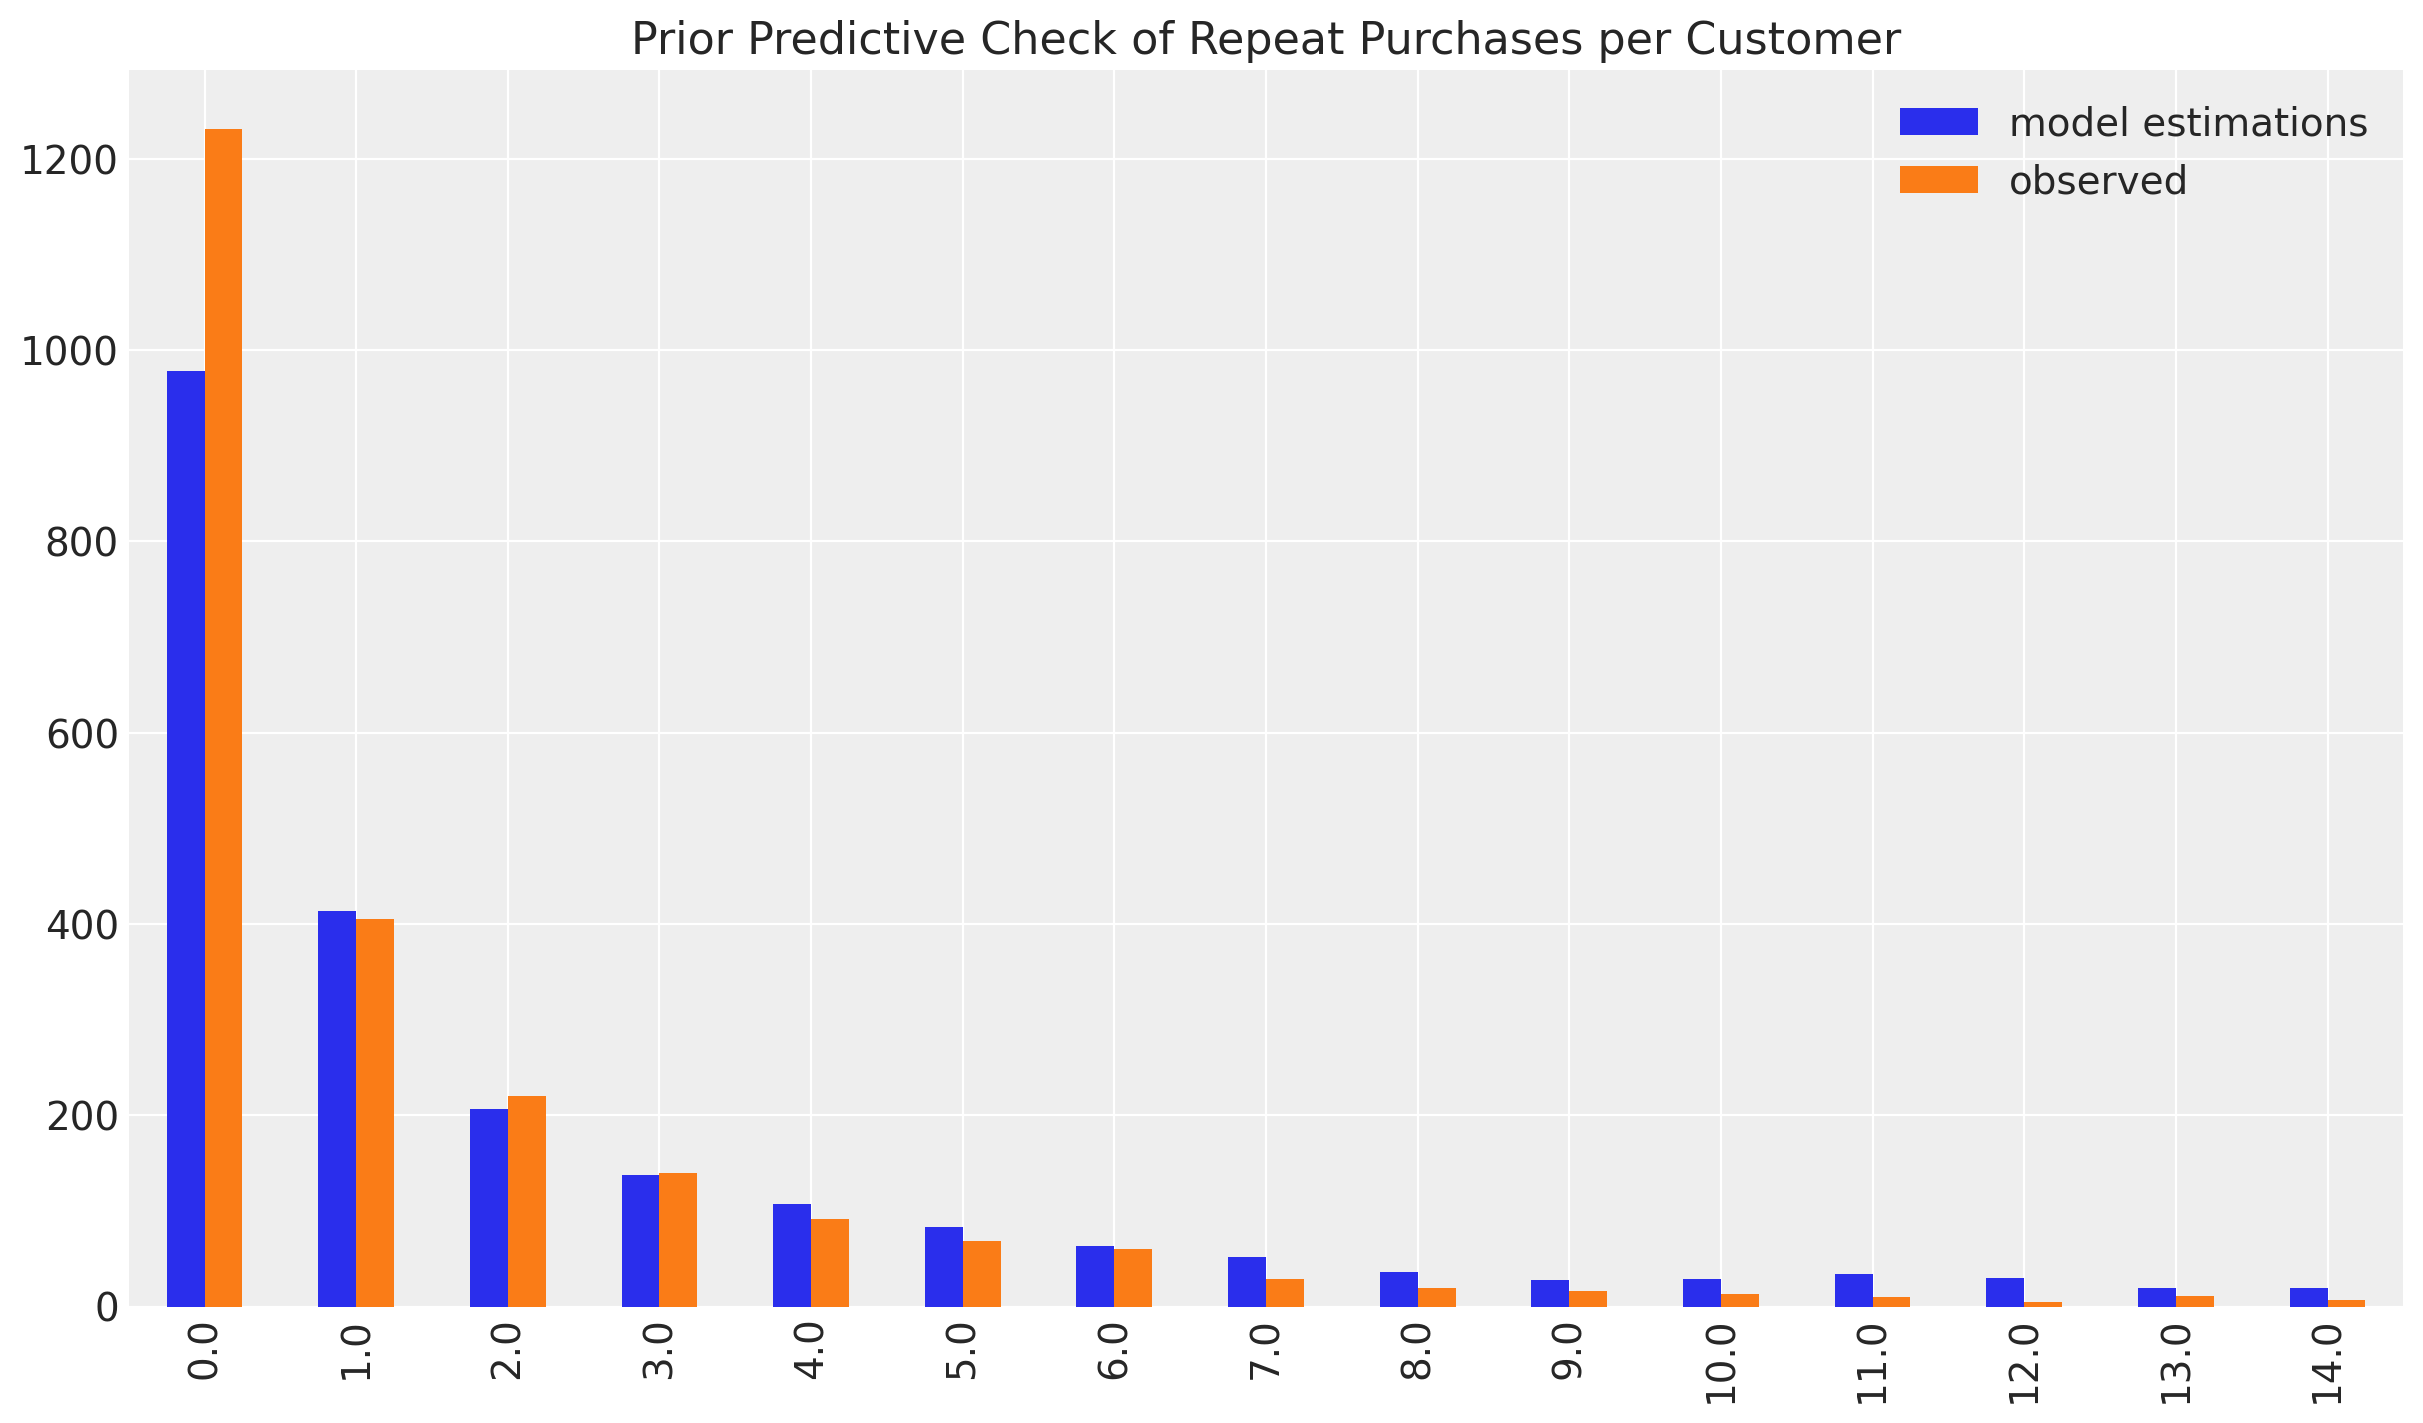

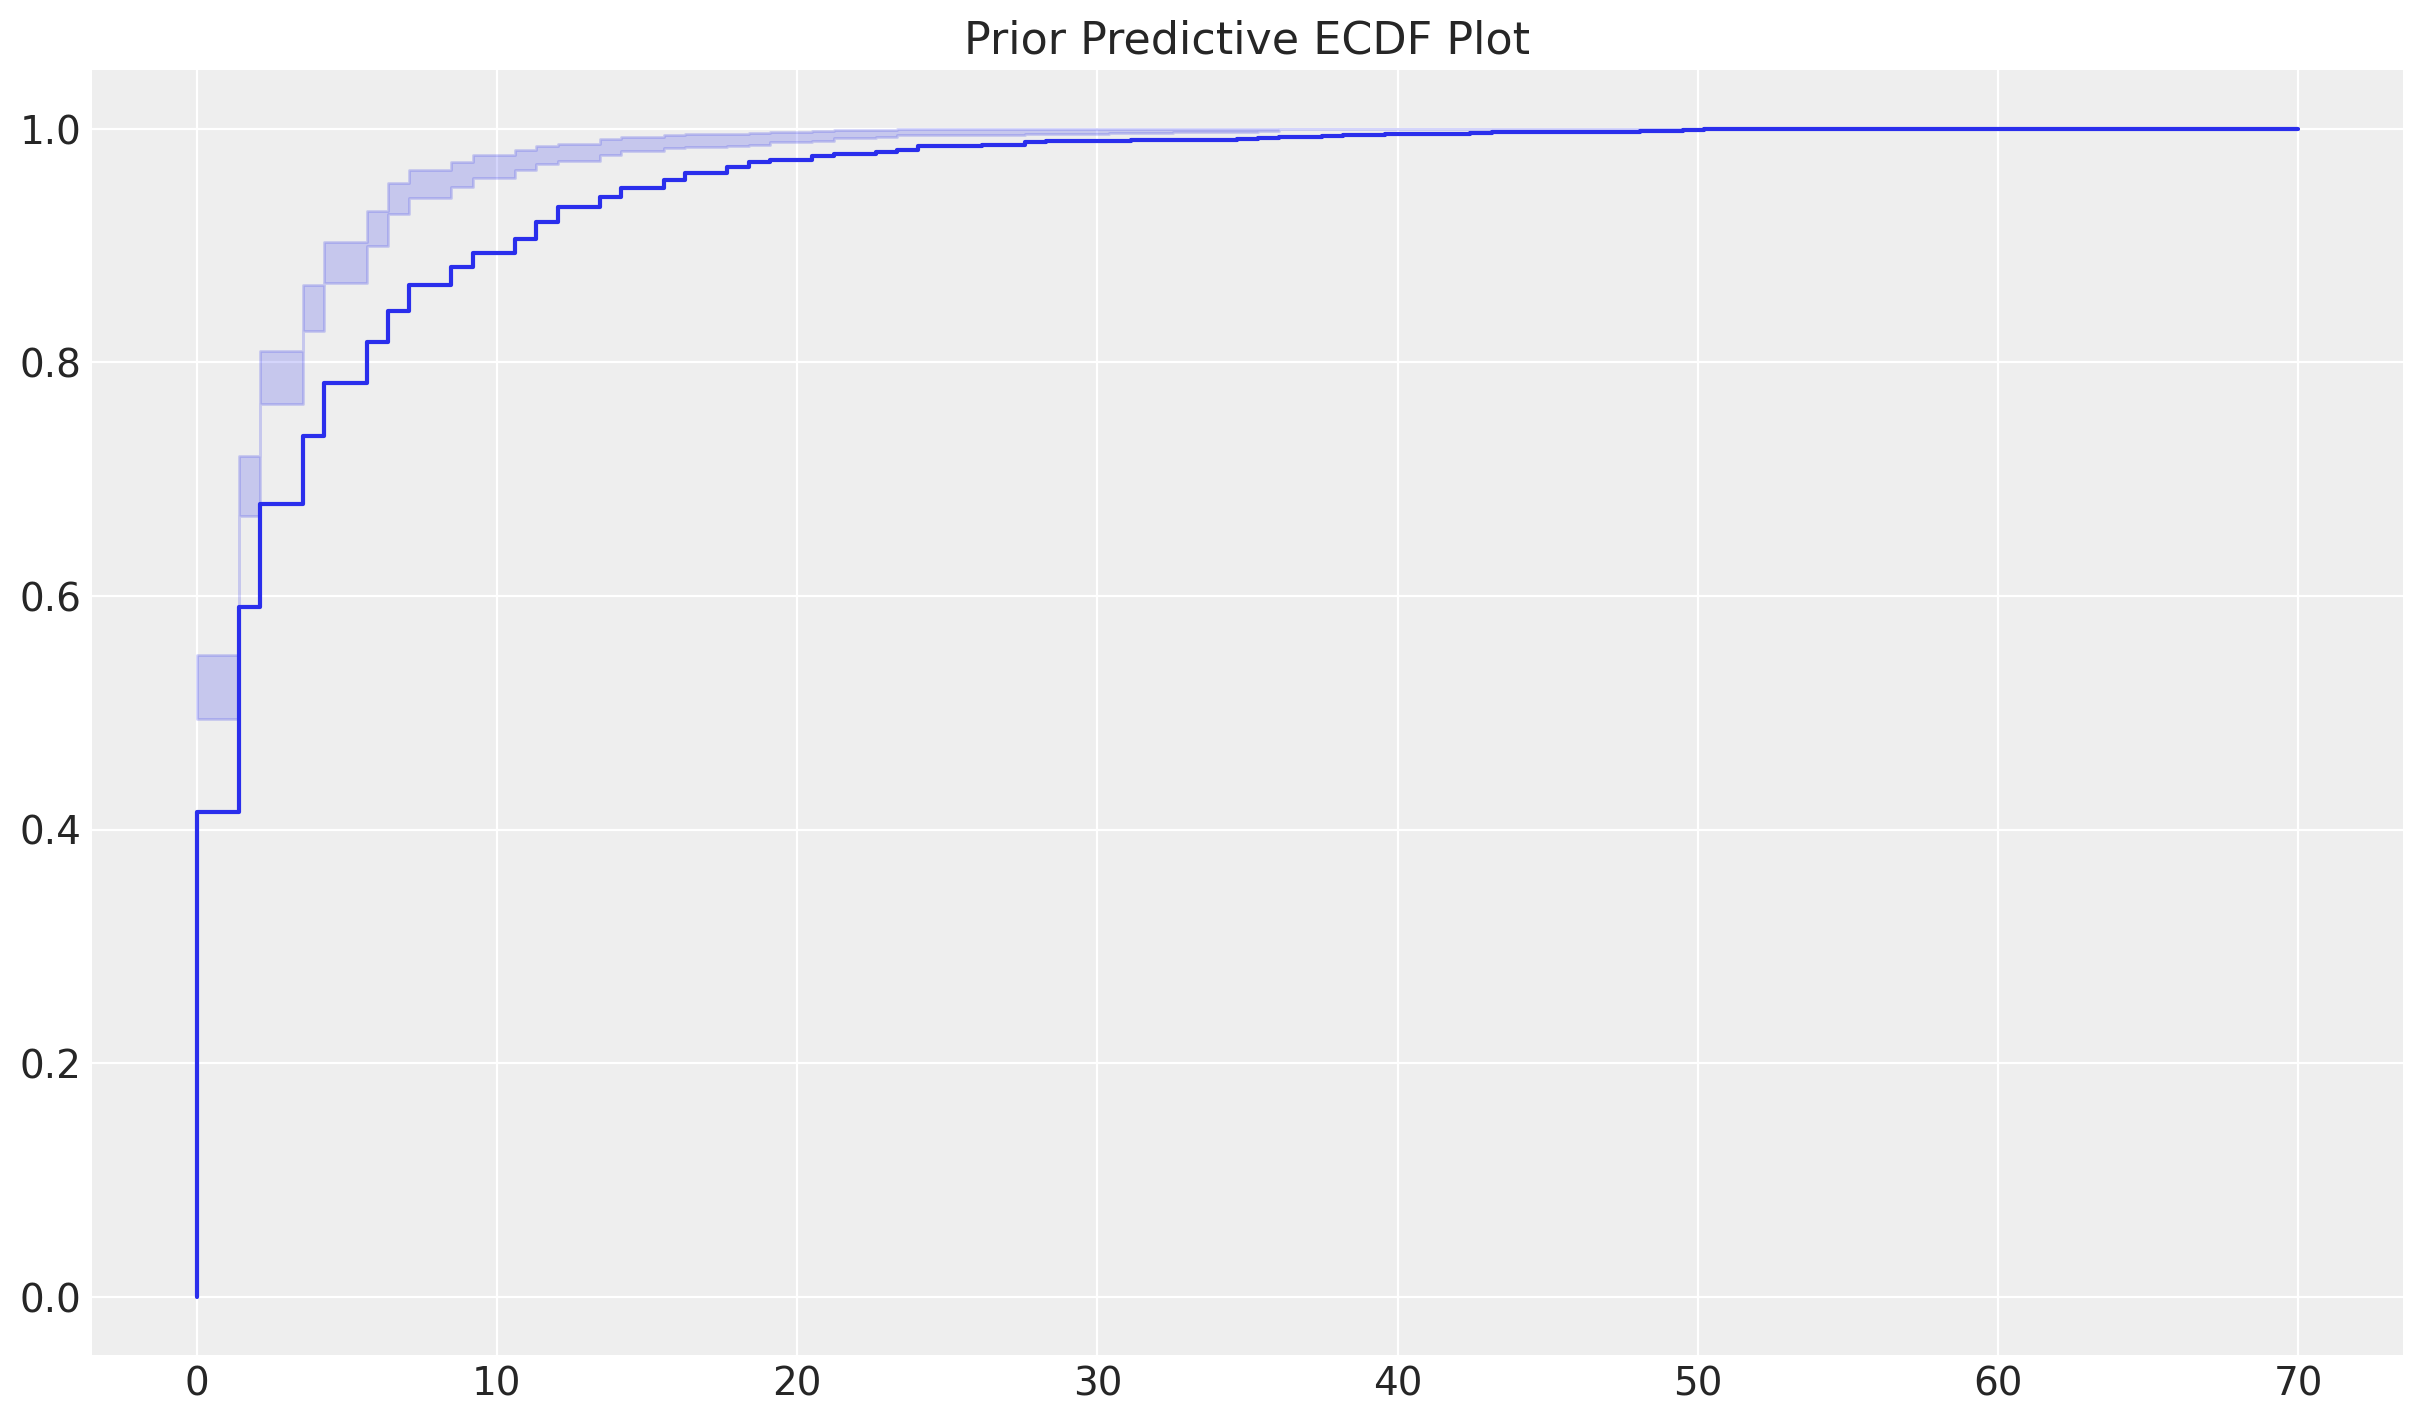

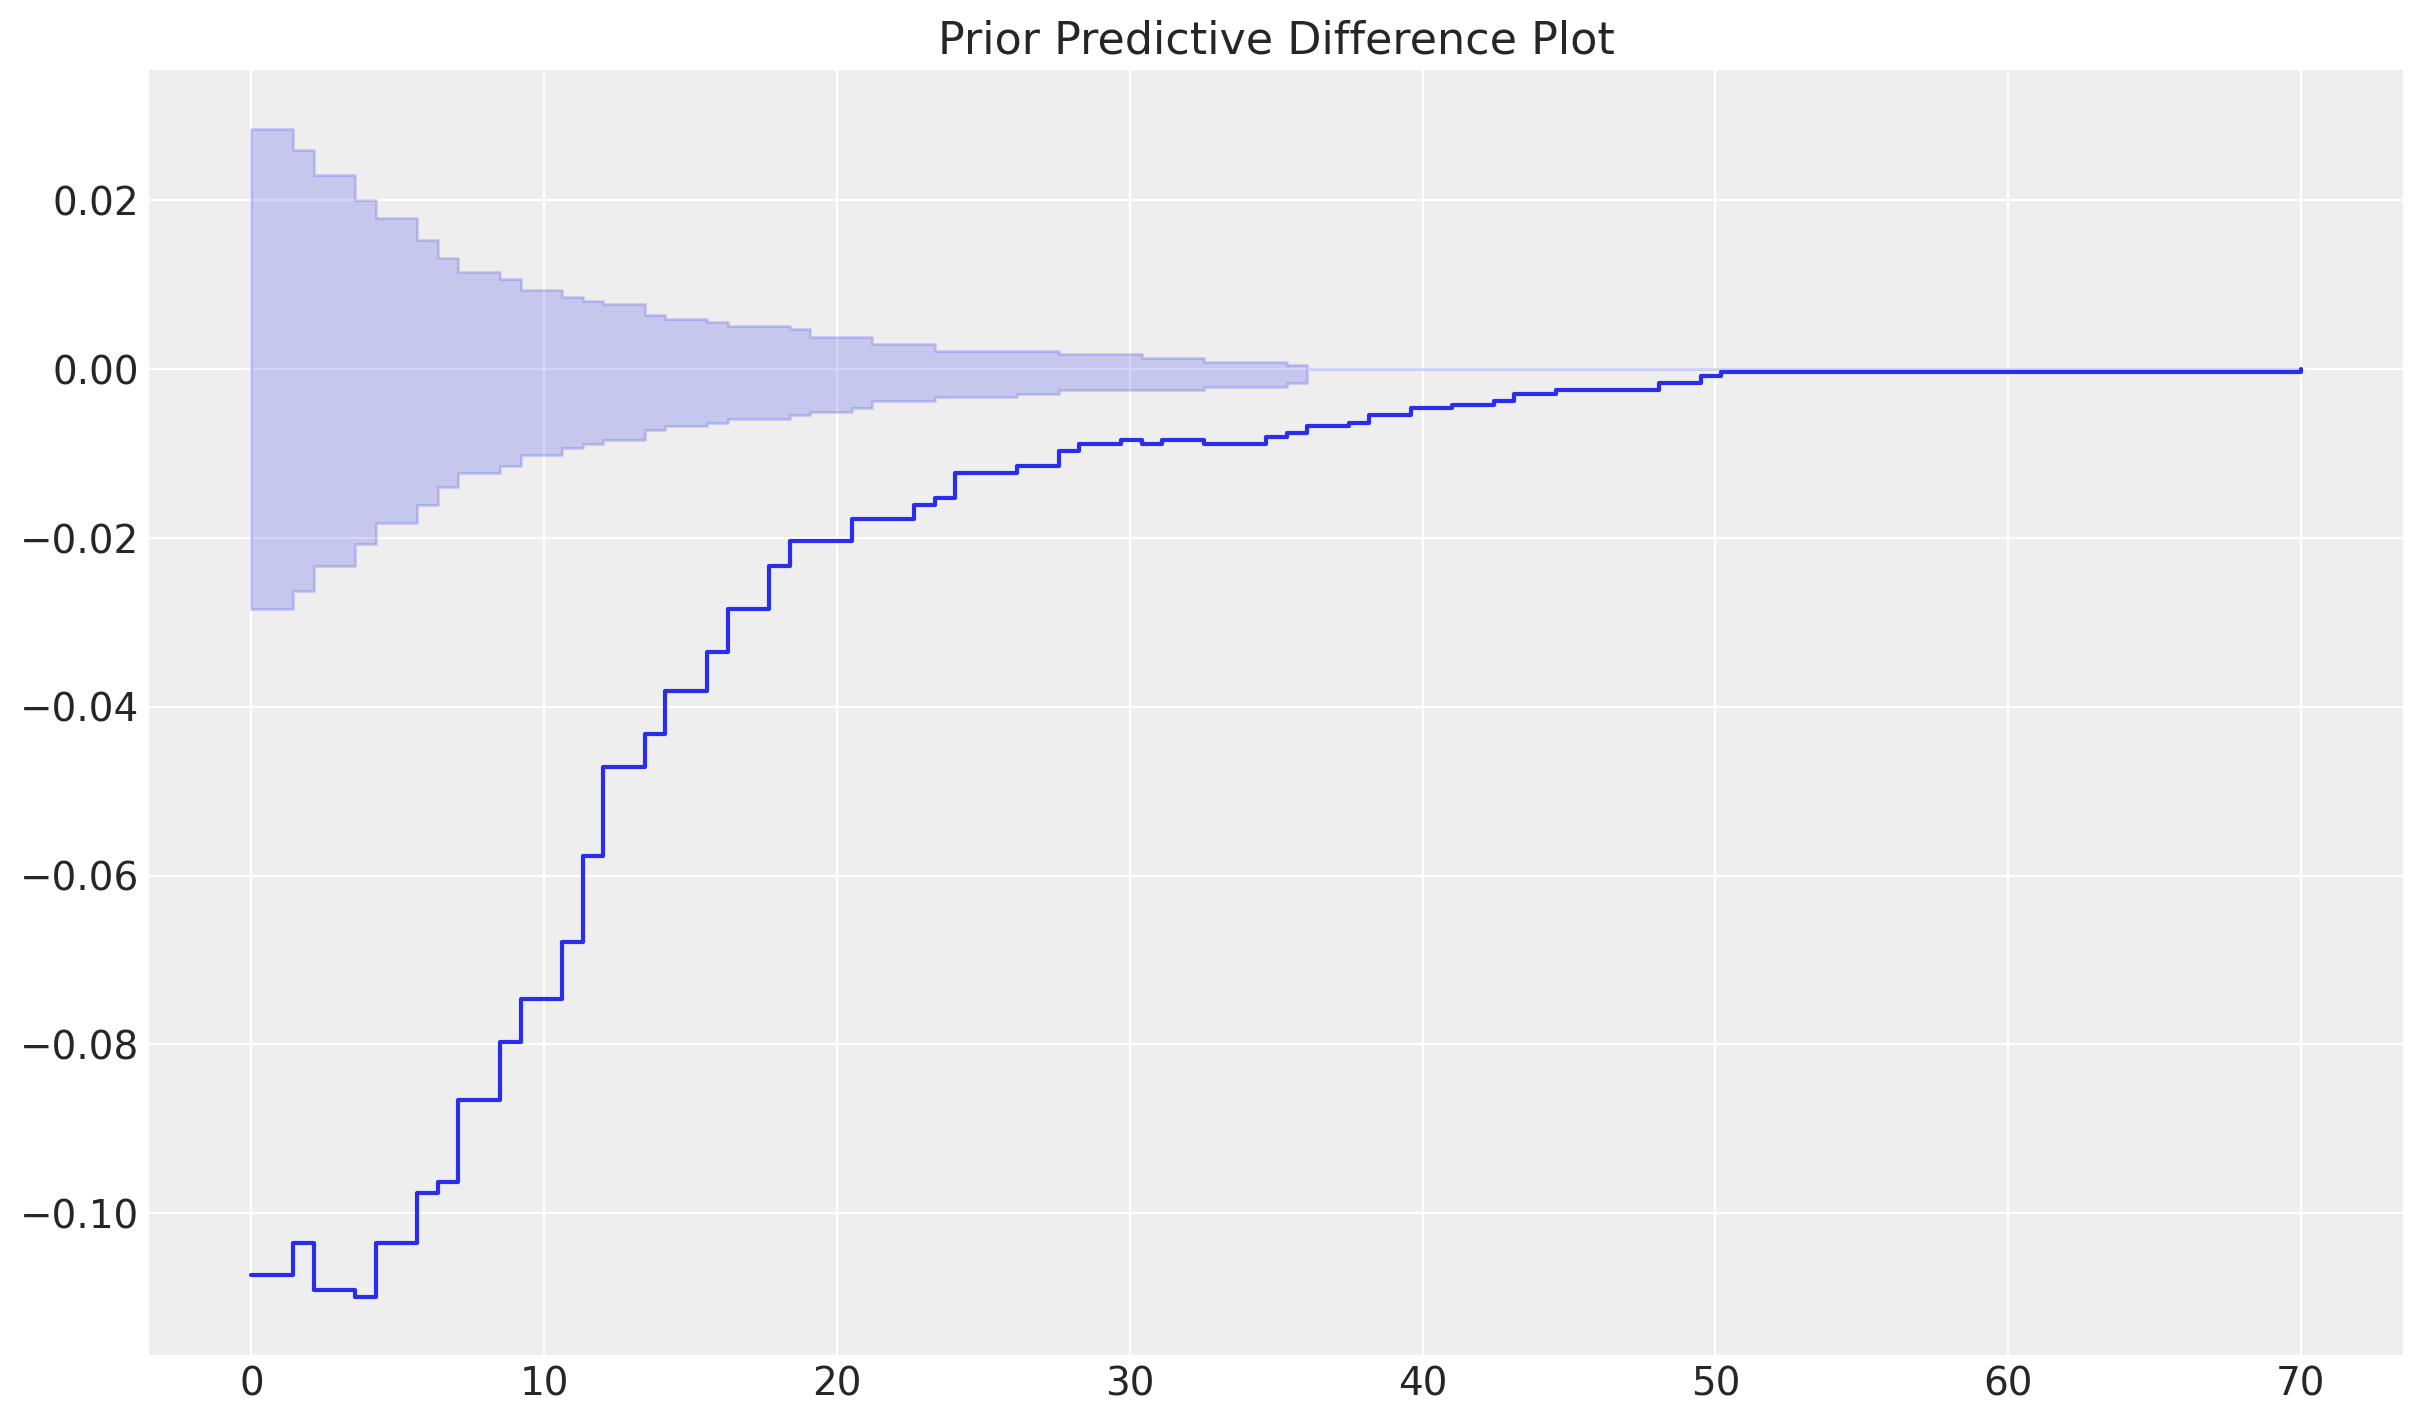

In [27]:
with pnbd_pymc.model:
    prior_idata = pm.sample_prior_predictive(random_seed=45, samples=1)

obs_freq = prior_idata.observed_data['recency_frequency'].sel(obs_var="frequency")
ppc_freq = prior_idata.prior_predictive['recency_frequency'].sel(obs_var="frequency")[0][0]

# PPC histogram plot
pd.DataFrame(
    {
        "model estimations": ppc_freq.to_pandas().value_counts().sort_index(),
        "observed": obs_freq.to_pandas().value_counts().sort_index()
        }
        ).head(15).plot(kind="bar", title = "Prior Predictive Check of Repeat Purchases per Customer")

# companion plots from ArviZ
az.plot_ecdf(ppc_freq,obs_freq, confidence_bands = True).set_title( "Prior Predictive ECDF Plot")
az.plot_ecdf(ppc_freq,obs_freq, confidence_bands = True, difference=True).set_title("Prior Predictive Difference Plot");

Here the `ParetoNBDModel` is simulating customer purchases from the prior distributions to compare against the obseved data. The priors we specified look reasonable for customers who have made 1-7 purchases, but does not model single-purchase customers well. The deviations beyond the confidence intervals of the Emperical Cumulative Distribution Function (ECDF) and Difference plots indicate the importance of single purchases customers - in fact they comprise over half the CDNOW sample dataset! 

Let's fit our model and run a *posterior* predictive check for comparison:

Output()

Sampling: [recency_frequency]


Output()

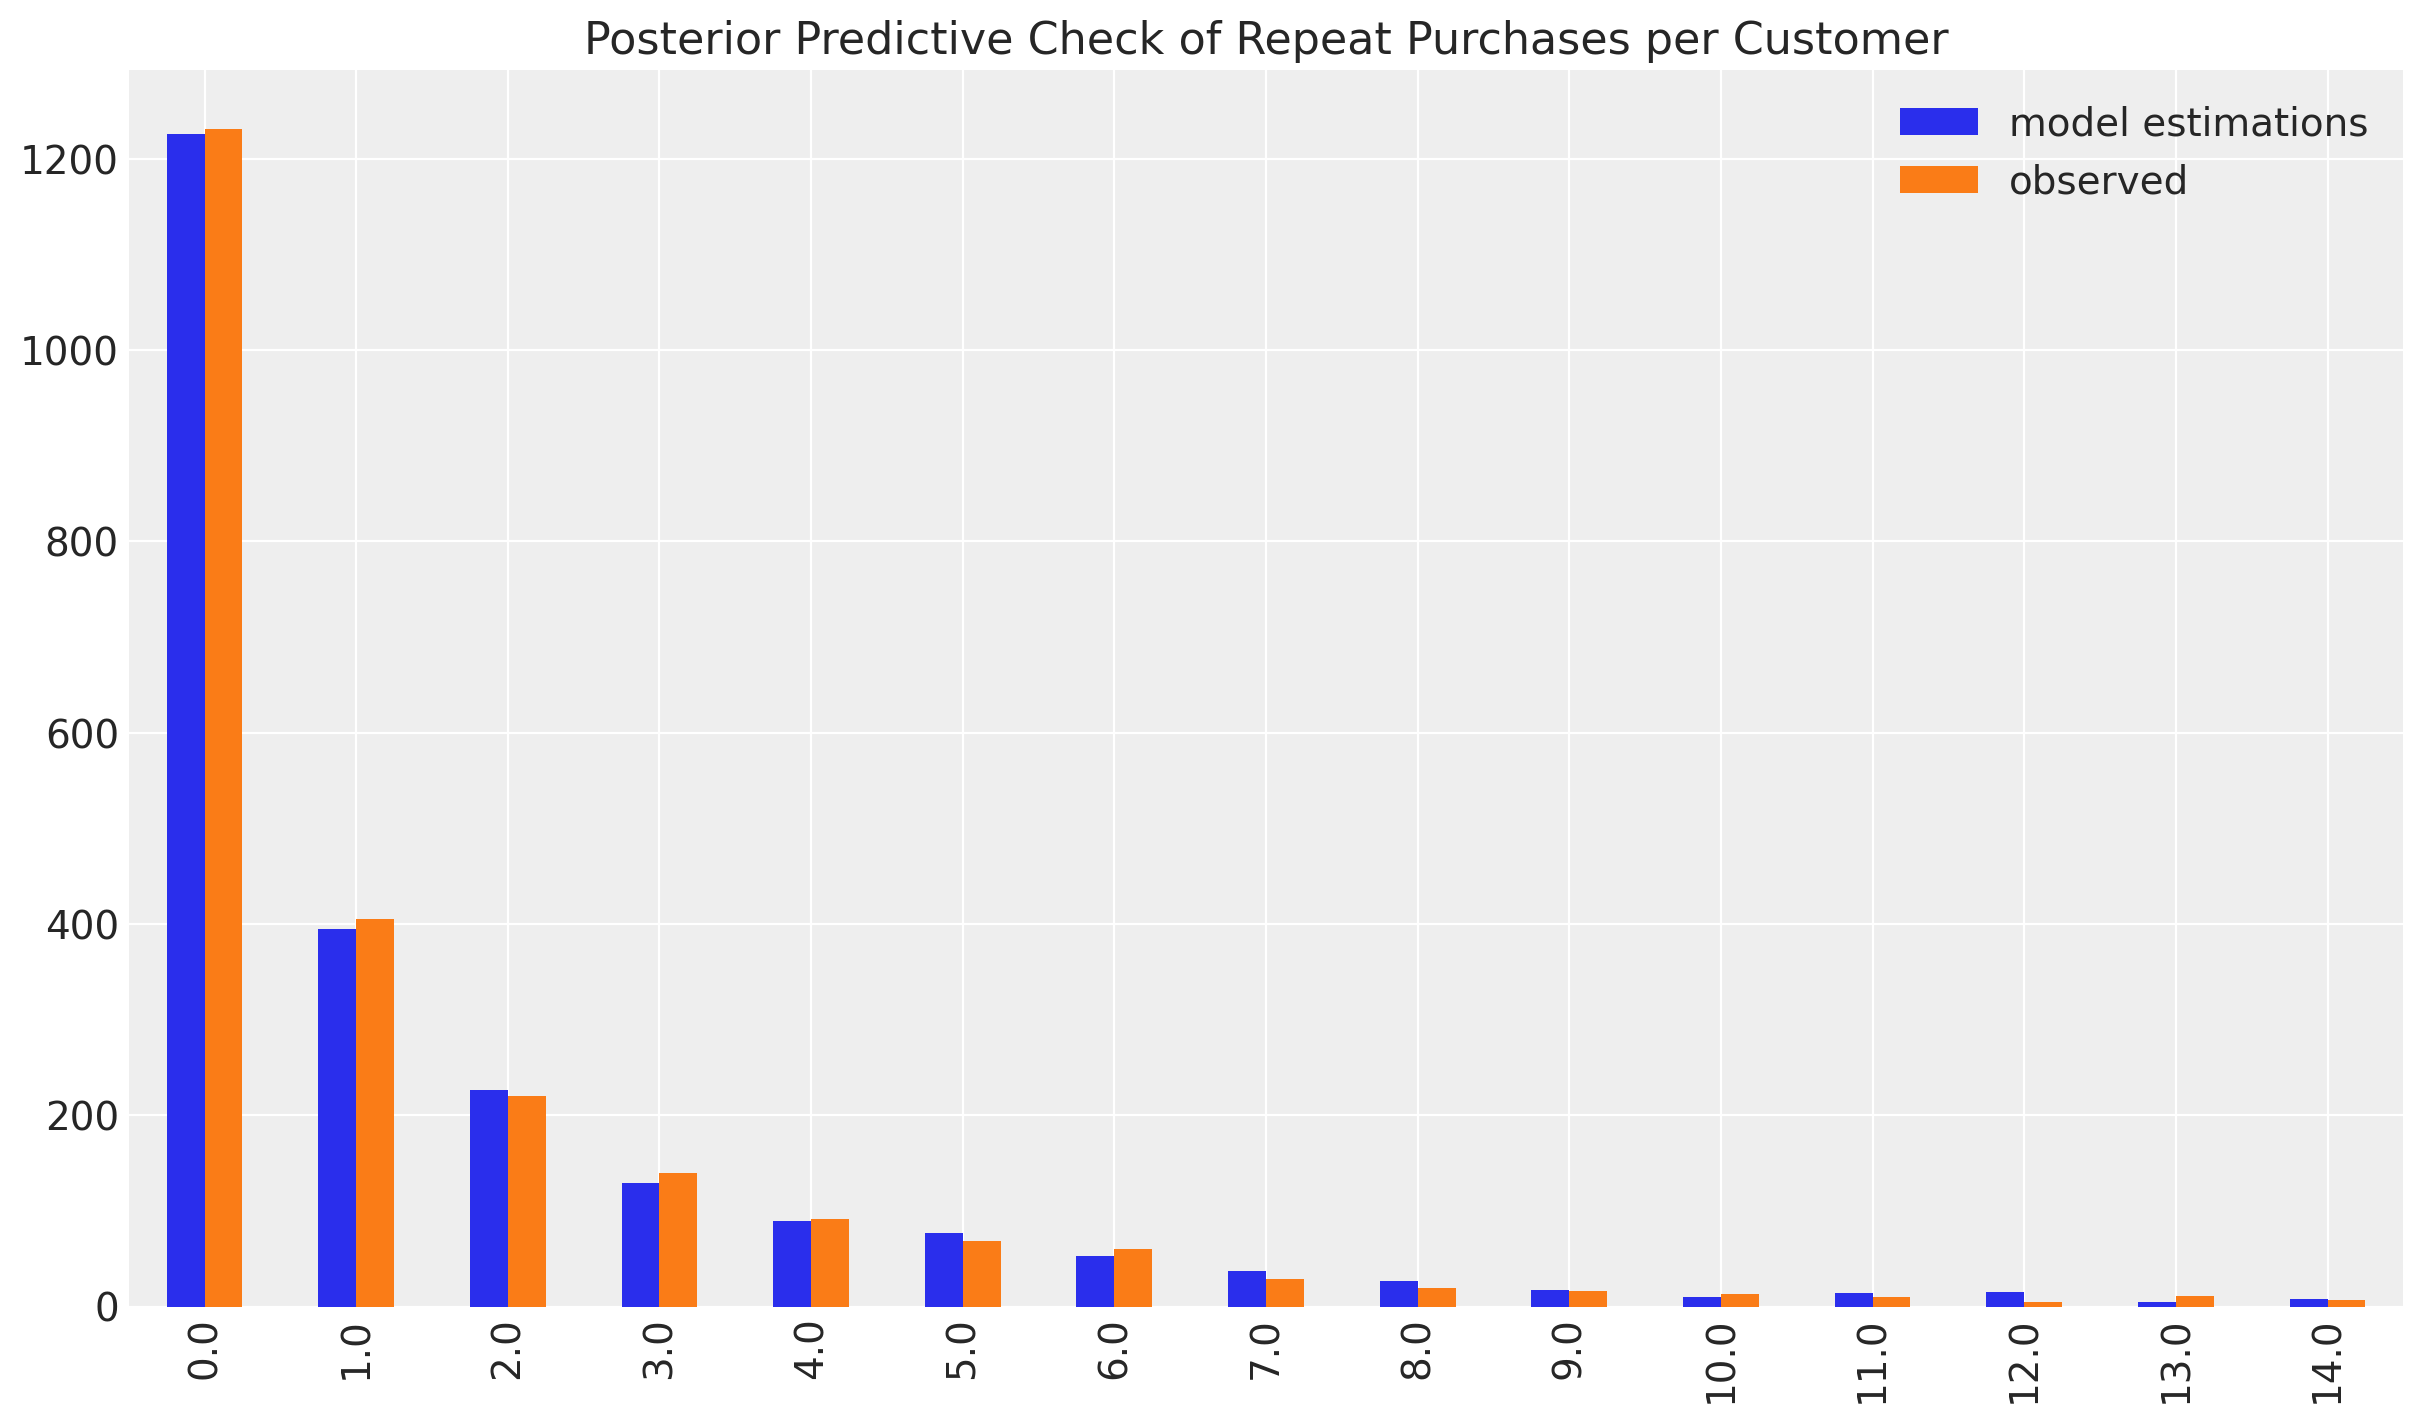

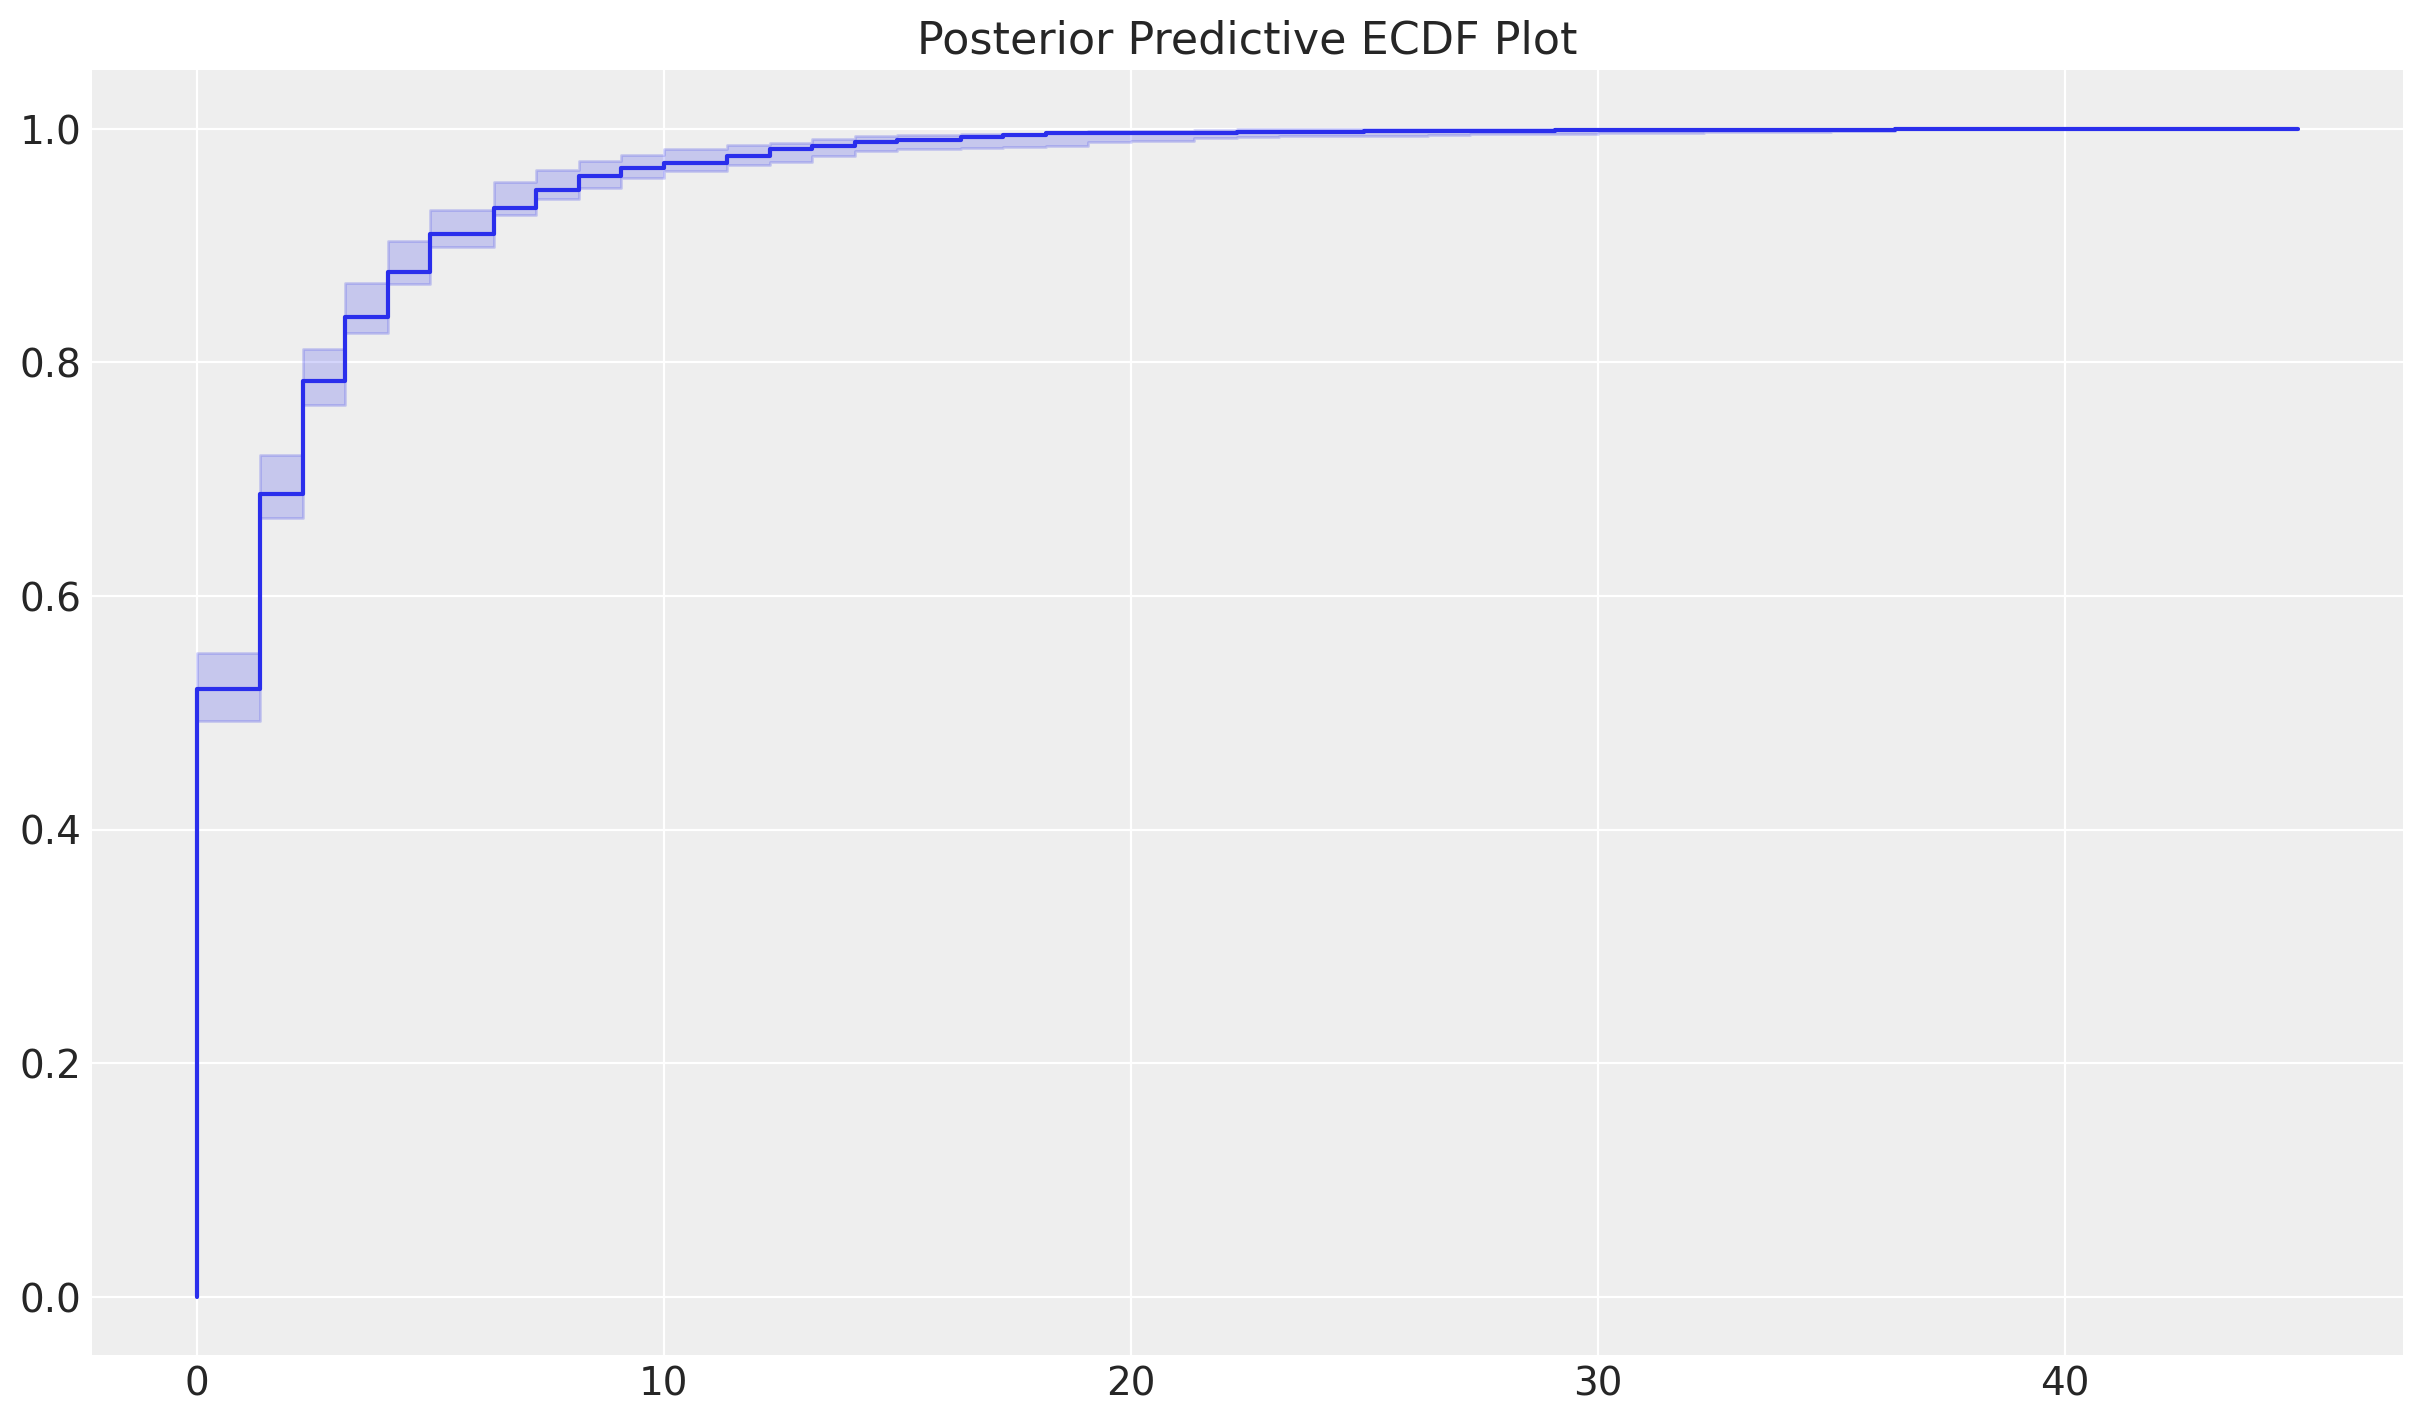

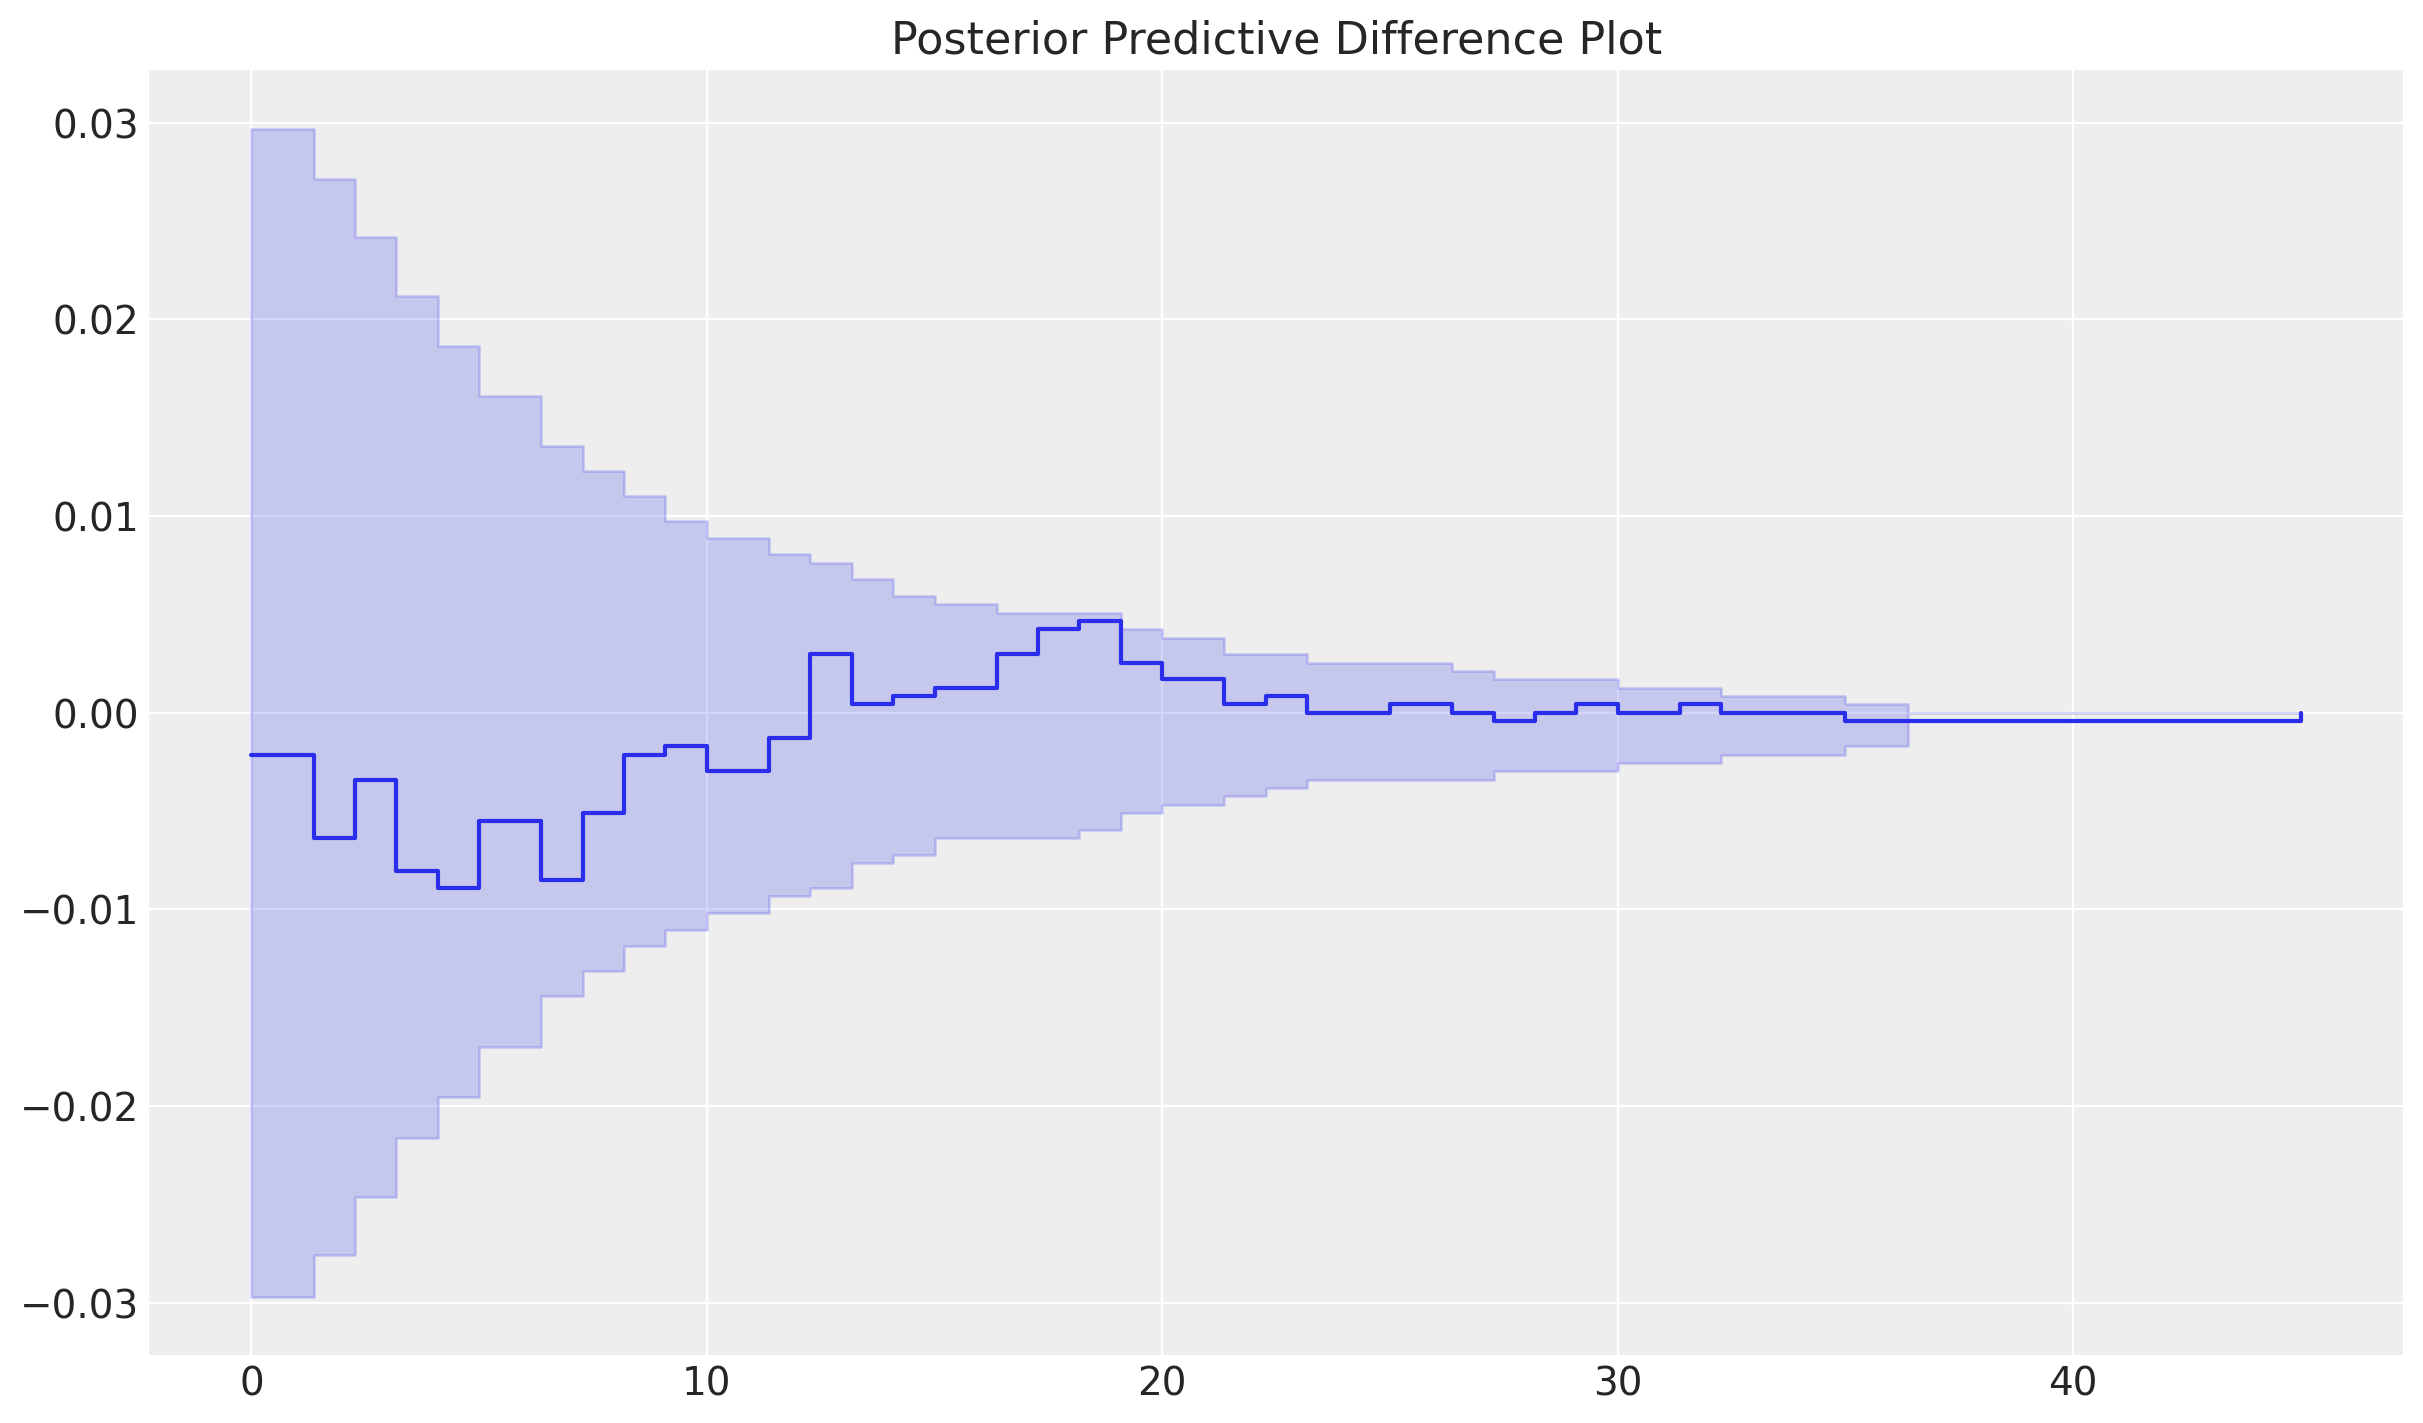

In [86]:
pnbd_pymc.fit()
map_fit = pnbd_pymc.fit_summary() # save for plotting later

obs_freq = pnbd_pymc.idata.observed_data['recency_frequency'].sel(obs_var="frequency")
ppc_freq = pnbd_pymc.distribution_new_customer_recency_frequency(rfm_data, random_seed=42).sel(chain=0, draw=0, obs_var="frequency")

# PPC histogram plot
pd.DataFrame(
    {
        "model estimations": ppc_freq.to_pandas().value_counts().sort_index(),
        "observed": obs_freq.to_pandas().value_counts().sort_index()
        }
        ).head(15).plot(kind="bar", title = "Posterior Predictive Check of Repeat Purchases per Customer")

# companion plots from ArviZ
az.plot_ecdf(ppc_freq,obs_freq, confidence_bands = True).set_title( "Posterior Predictive ECDF Plot")
az.plot_ecdf(ppc_freq,obs_freq, confidence_bands = True, difference=True).set_title("Posterior Predictive Difference Plot");

Our fitted model is able to reliably simulate customer behavior!

# Full Bayesian Inference

MAP fits estimate only scalar values for $r$, $\alpha$, $s$, and $\beta$, but with full Bayesian sampling we can infer the posterior probability distributions for these parameters, illustrating uncertainty in our estimates as well as enabling prediction intervals.

NUTS is the default sampler in `pymc-marketing`, which samples from the posterior by exploring the gradients of the probability space. However, NUTS sampling with `ParetoNBDModel` can be quite slow due to the complexity of the likelihood expression. In fact, the mathematical complexity of this model is what motivated the development of the [`BetaGeoModel`](https://www.pymc-marketing.io/en/stable/notebooks/clv/bg_nbd.html) in 2005. The BG/NBD model makes some simplifying assumptions and sacrifices functionality in customer dropout estimation for better computational performance.

To save time and computational costs, it is recommended to use gradient-free methods such as `pm.DEMetropolisZ`. This often requires more samples during fitting, so if any `rhat statistic` warnings are encountered, increase the size of the `tune` and `draw` parameters until the warning no longer appears.

In [35]:
pnbd_full = clv.ParetoNBDModel(data=rfm_data)
pnbd_full.build_model()

with pnbd_full.model:
    pnbd_full.idata = pm.sample(step=pm.DEMetropolisZ(),tune=2500, draws=3000, idata_kwargs={"log_likelihood": True})

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [r, alpha, s, beta]


Output()

Sampling 4 chains for 2_500 tune and 3_000 draw iterations (10_000 + 12_000 draws total) took 6 seconds.


Output()

In [39]:
pnbd_full.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,15.687,1.065,13.749,17.710,0.036,0.026,856.0,1204.0,1.01
beta,12.716,3.625,6.003,19.037,0.120,0.085,924.0,1341.0,1.01
r,0.621,0.046,0.535,0.704,0.002,0.001,805.0,1116.0,1.01
s,0.431,0.061,0.319,0.545,0.002,0.002,849.0,1150.0,1.01


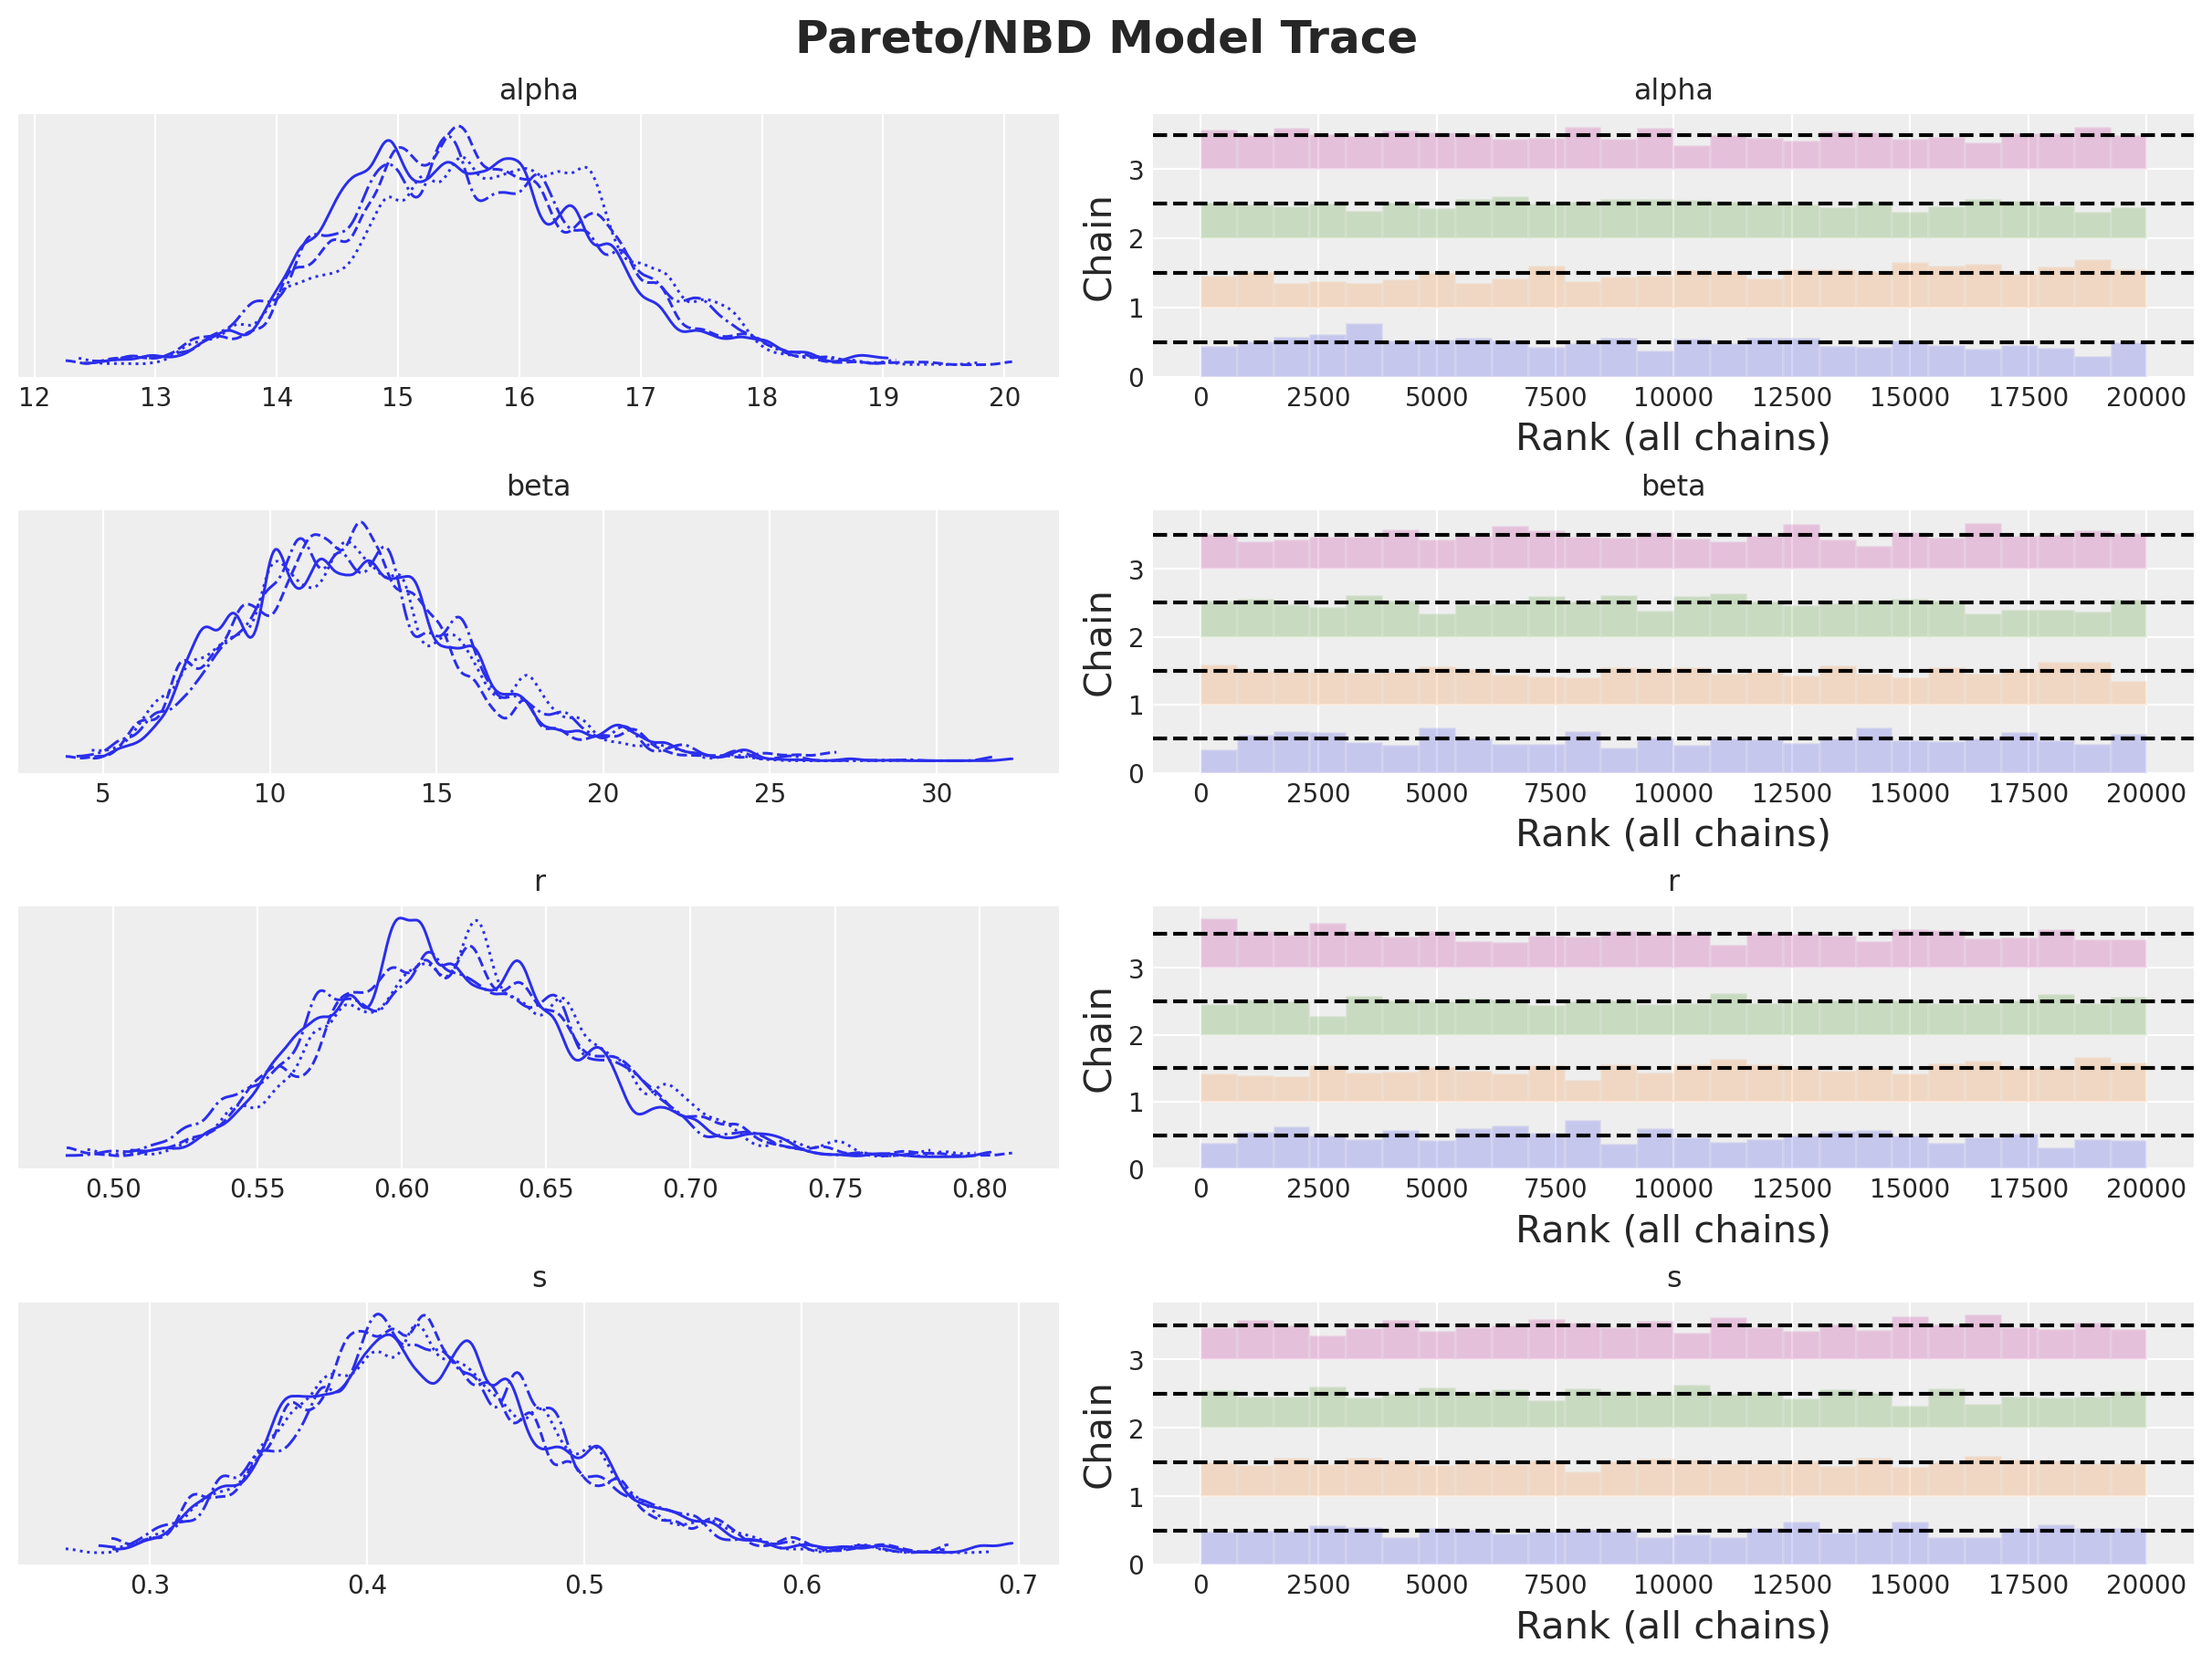

In [34]:
axes = az.plot_trace(
    data=pnbd_full.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Pareto/NBD Model Trace", fontsize=18, fontweight="bold");

In [24]:
pnbd_full.idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Let's see how the DEMZ posteriors compare to the MAP estimations:

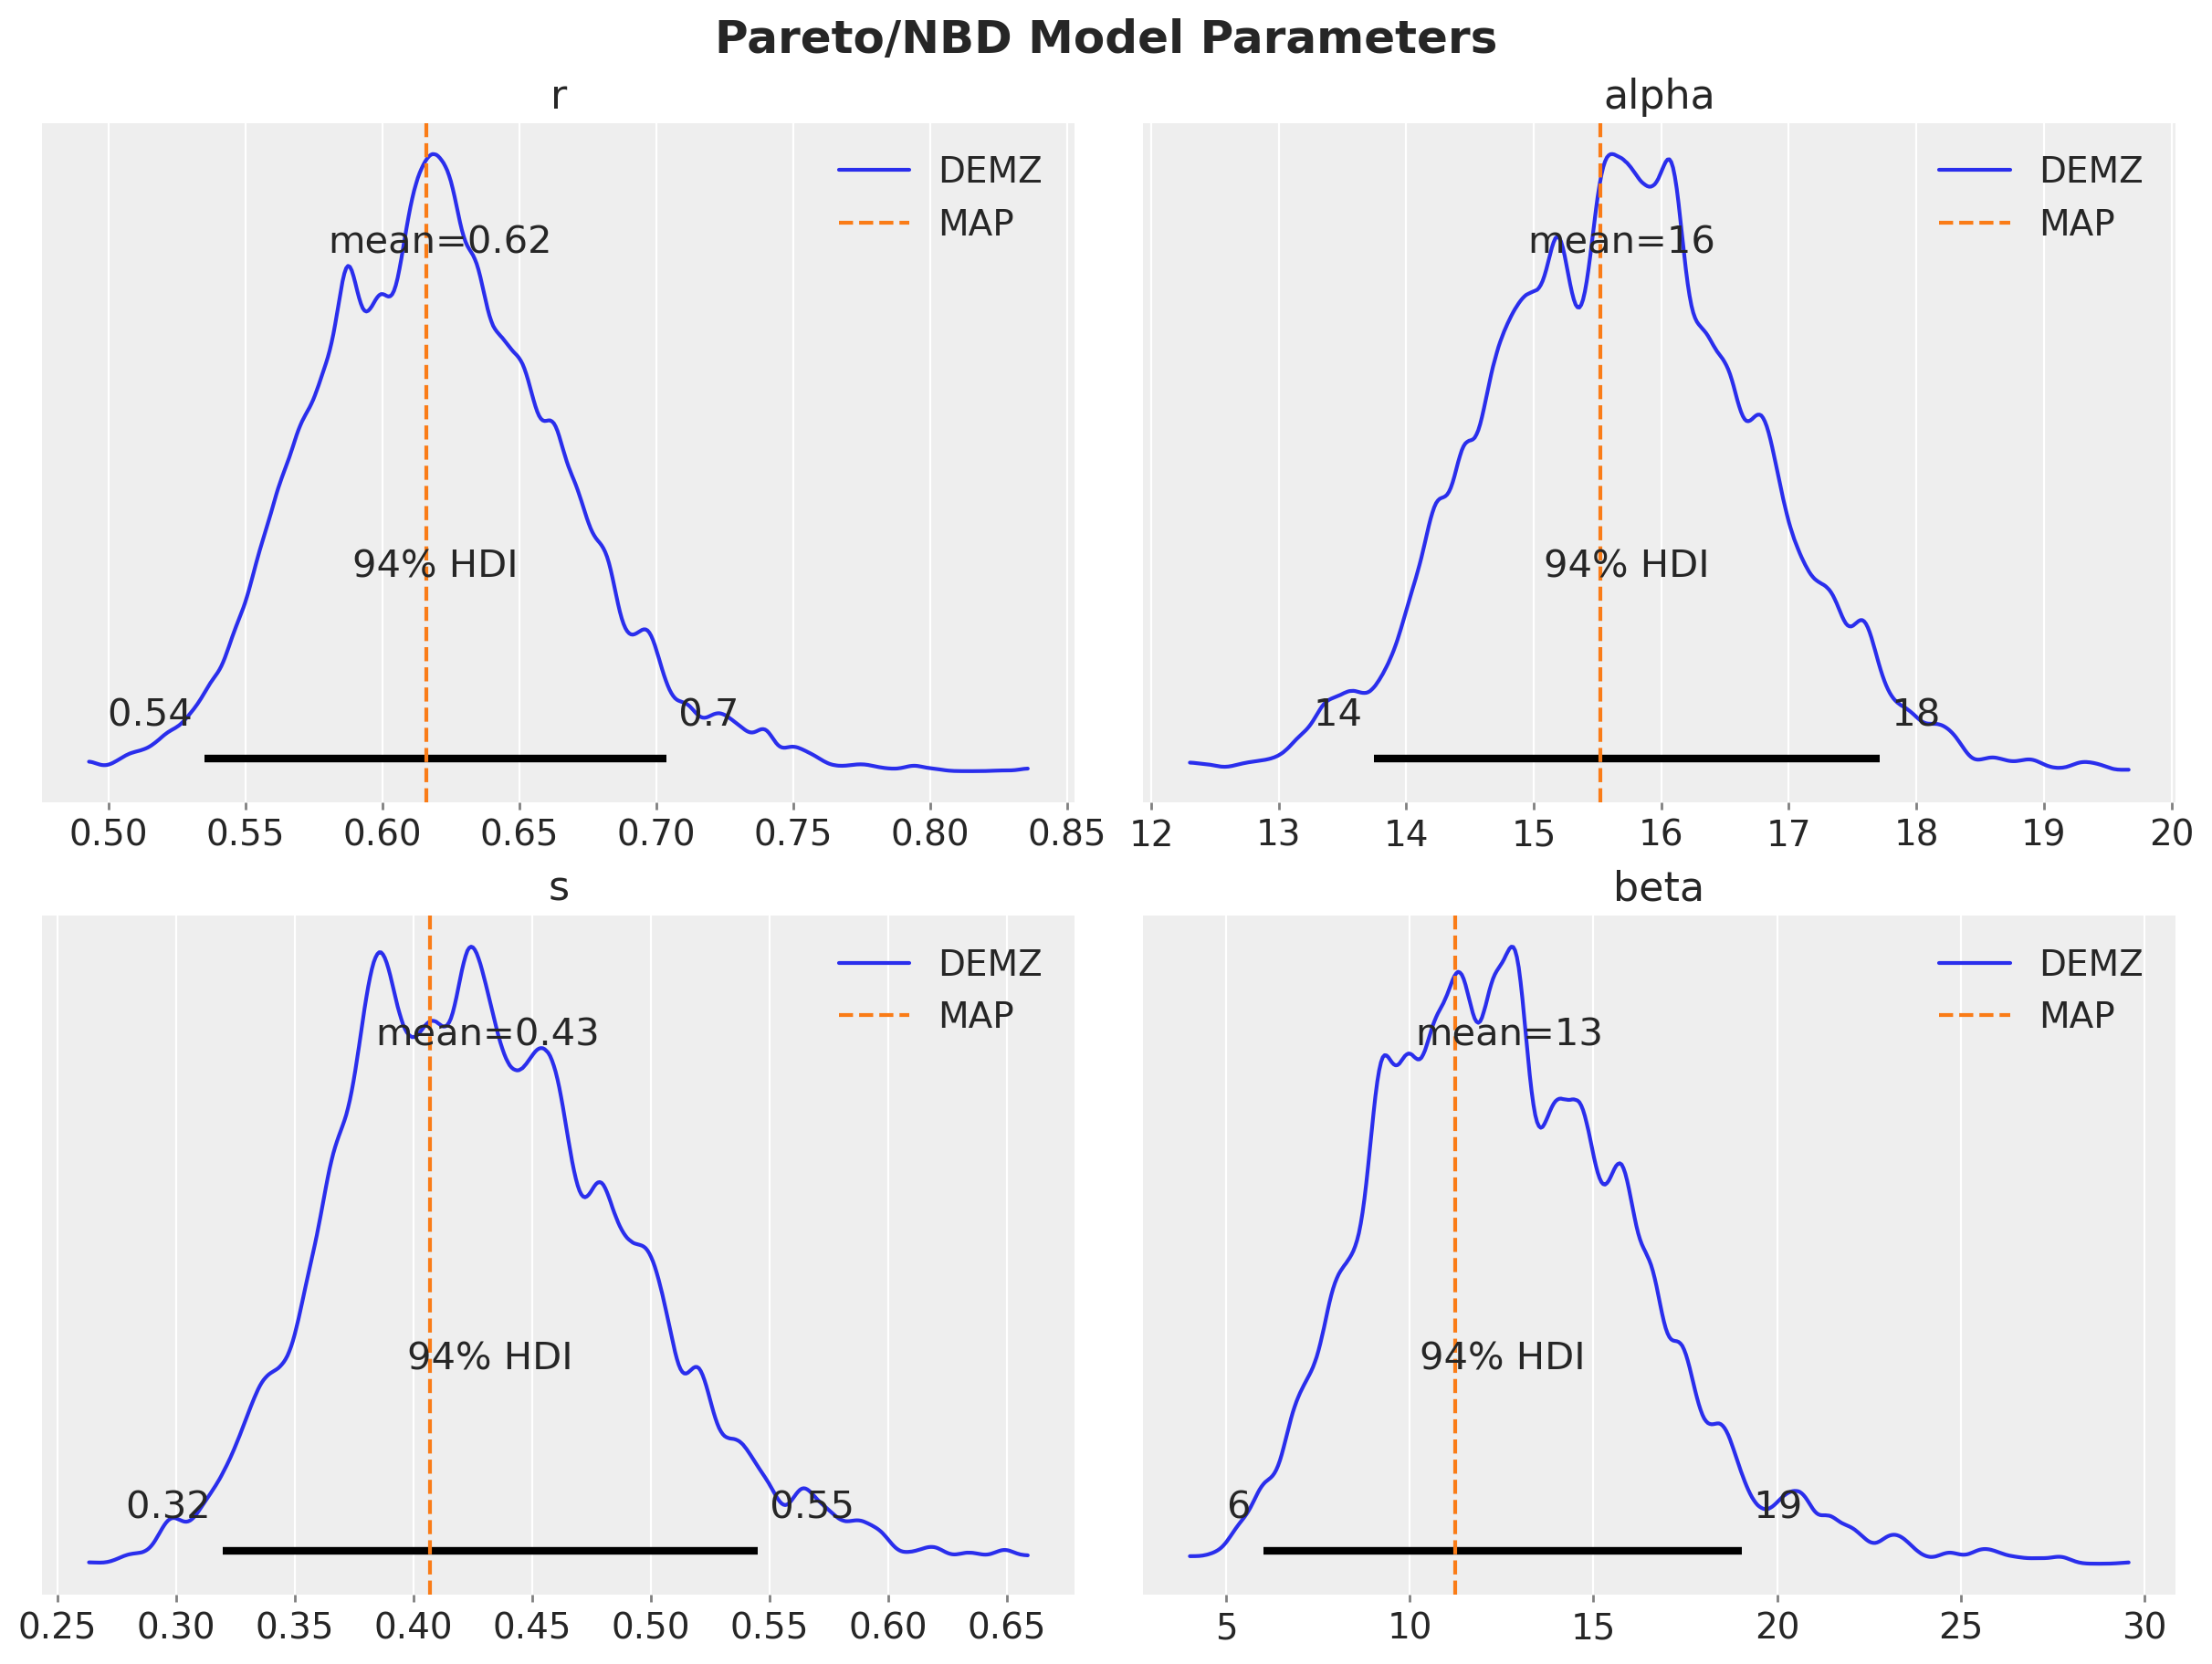

In [40]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 9), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for i, var_name in enumerate(["r", "alpha", "s", "beta"]):
    ax = axes[i]
    az.plot_posterior(
        pnbd_full.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        ax=ax,
        label="DEMZ",
    )
    ax.axvline(x=map_fit[var_name], color="C1", linestyle="--", label="MAP")
    ax.legend(loc="upper right")
    ax.set_title(var_name)

plt.gcf().suptitle("Pareto/NBD Model Parameters", fontsize=18, fontweight="bold");

After fititing, models can be persisted for later use:

In [63]:
pnbd_pymc.save("pnbd.nc")
pnbd_pymc.load("pnbd.nc")

Pareto/NBD
                r ~ Weibull(2, 1)
            alpha ~ Weibull(2, 10)
                s ~ Weibull(2, 1)
             beta ~ Weibull(2, 10)
recency_frequency ~ ParetoNBD(r, alpha, s, beta, <constant>)

# Predictive Methods

The Pareto/NBD model supports a variety of predictive methods:

- `expected_purchases`
- `expected_probability_alive`
- `expected_purchases_new_customer`
- `expected_purchase_probability`

Let's take a sample of users:

In [54]:
example_customer_ids = [1, 5, 10, 18, 46, 1413]

rfm_sample = rfm_data.query("customer_id.isin(@example_customer_ids)")

rfm_sample.sort_values(by="frequency")

,customer_id,frequency,recency,T
4,5,0.0,0.0,78.0
9,10,0.0,0.0,78.0
17,18,1.0,5.0,78.0
0,1,3.0,49.0,78.0
1412,1413,19.0,54.0,71.0
45,46,21.0,73.0,78.0


Observe customers 5 & 10 are *non-repeat buyers*, whereas 1413 and 46 are *frequent buyers*.

### Expected Number of Purchases
Let's plot each customer's expected number of purchases for the next $90$ time periods:

In [96]:
steps = 90

expected_purchases_steps = xr.concat(
    objs=[
        pnbd_full.expected_purchases(
            data=rfm_sample,
            future_t=t,
        )
        for t in progress_bar(range(steps))
    ],
    dim="t",
).transpose(..., "t")

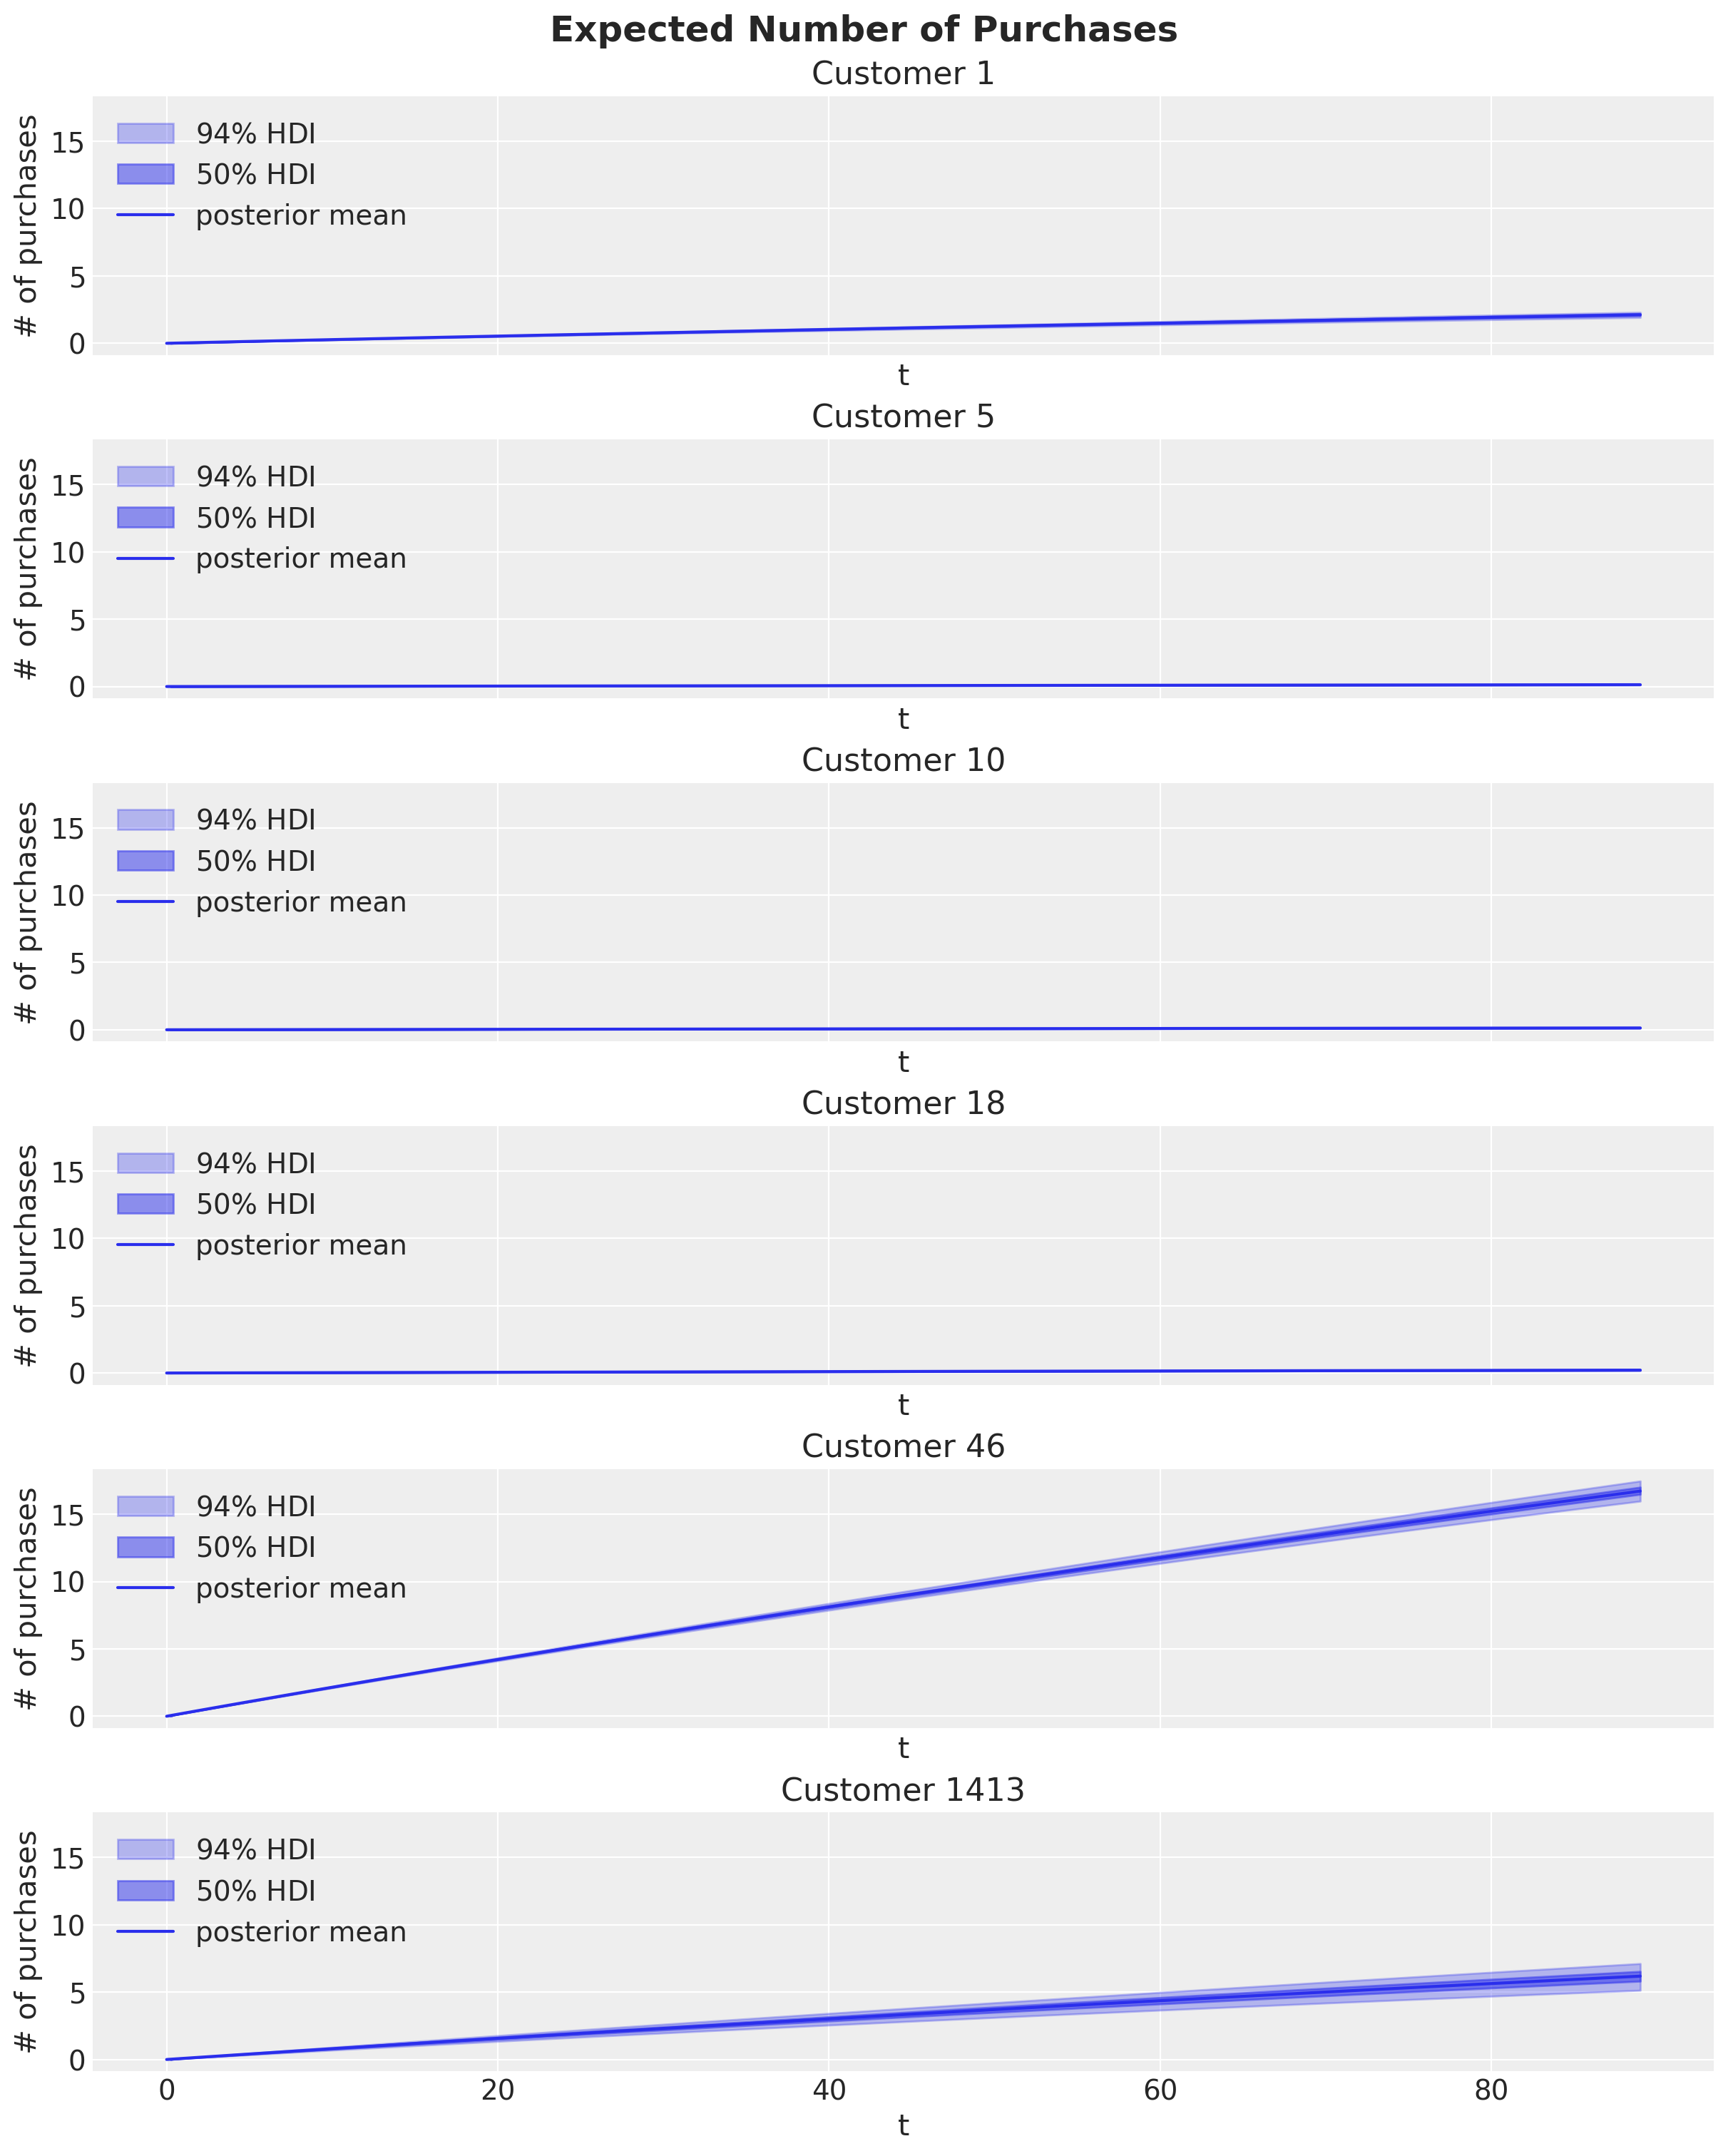

In [106]:
fig, axes = plt.subplots(
    nrows=len(example_customer_ids),
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    customer_expected_purchases_steps = expected_purchases_steps.sel(
        customer_id=customer_id
    )
    az.plot_hdi(
        range(steps),
        customer_expected_purchases_steps,
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        range(steps),
        customer_expected_purchases_steps,
        hdi_prob=0.5,
        color="C0",
        fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
        ax=ax,
    )
    ax.plot(
        range(steps),
        customer_expected_purchases_steps.mean(dim=("chain", "draw")),
        color="C0",
        label="posterior mean",
    )
    ax.legend(loc="upper left")
    ax.set(title=f"Customer {customer_id}", xlabel="t", ylabel="# of purchases")

axes[-1].set(xlabel="t")
plt.gcf().suptitle("Expected Number of Purchases", fontsize=18, fontweight="bold");

Note models fit with MAP only provide scalar predictions, but HDI prediction intervals are available if the model is fit with full posteriors.

Observe the large number of purchases expected from the frequent buyers (Customers 46 and 1413) whereas little or no future activity is expected of the remaining customers.

# Expected Probability Alive
Let's check the probability our customers are still alive.

In [ ]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(9, 9),
    layout="constrained"
)
for idx, ax in enumerate(axes.flatten()):
    plot_conditional_probability_alive(p_alive_sample, p_alive, idx, ax)

fig.suptitle("Conditional Probability Alive", fontsize=16);

In [100]:
steps = 90

expected_probability_alive_steps = xr.concat(
    objs=[
        pnbd_full.expected_probability_alive(
            rfm_sample,
            future_t=t,  # add t days
        )
        for t in progress_bar(range(steps))
    ],
    dim="t",
).transpose(..., "t")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


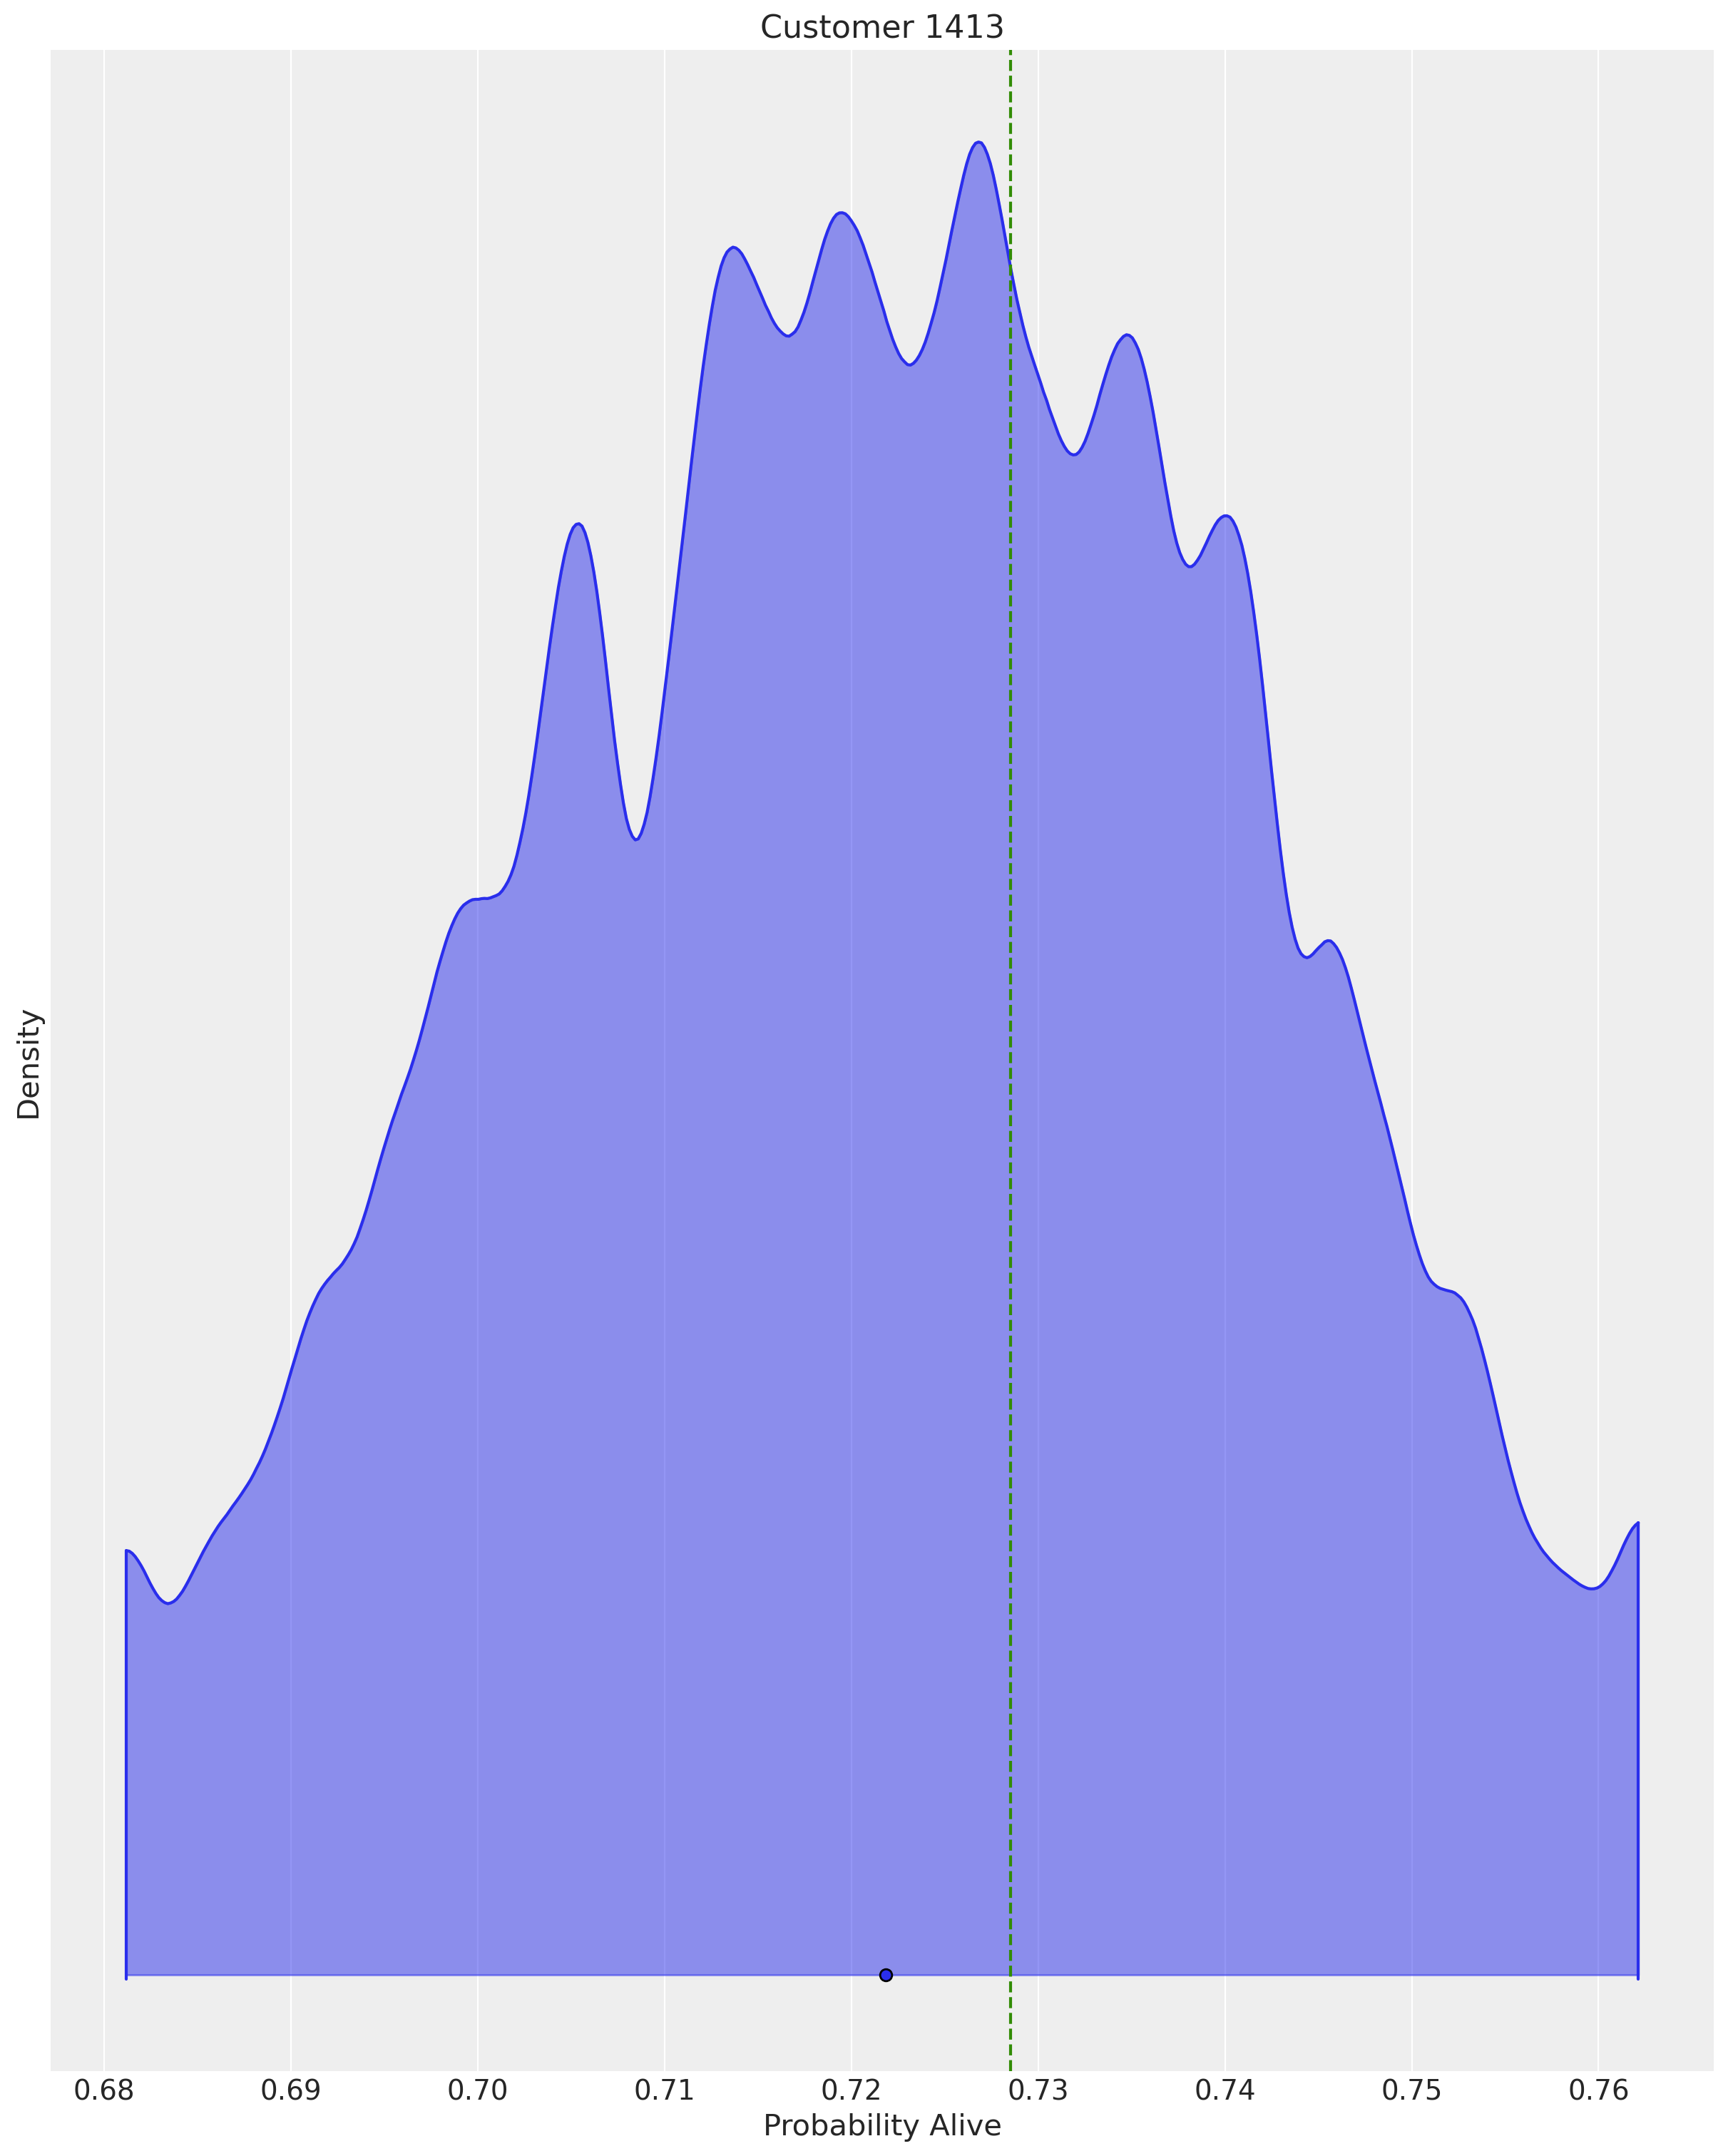

In [147]:
#pnnbd_full
fig, axes = plt.subplots(
    nrows=1, #should be 3
    ncols=1, #should be 3
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

#axes = axes.flatten()


cust1_alive = pnbd_full.expected_probability_alive(
            rfm_sample,
            future_t=0,
        ).sel(customer_id=1)

map_alive = pnbd_pymc.expected_probability_alive().sel(customer_id=1)

#pnbd_pymc
# https://python.arviz.org/en/stable/api/generated/arviz.plot_density.html
az.plot_density(cust1_alive, shade=0.5, ax=axes)
axes.axvline(x=map_alive, color="C2", linestyle="--")
axes.legend(loc="upper right")
axes.set(title=f"Customer {customer_id}", xlabel="Probability Alive", ylabel="Density");


# sns.kdeplot(x=cust1_alive, color="C0", fill=True, ax=ax);
# ax.axvline(x=pnbd_pymc[idx], color="C1", linestyle="--")
# ax.set(title=f"idx={idx}")

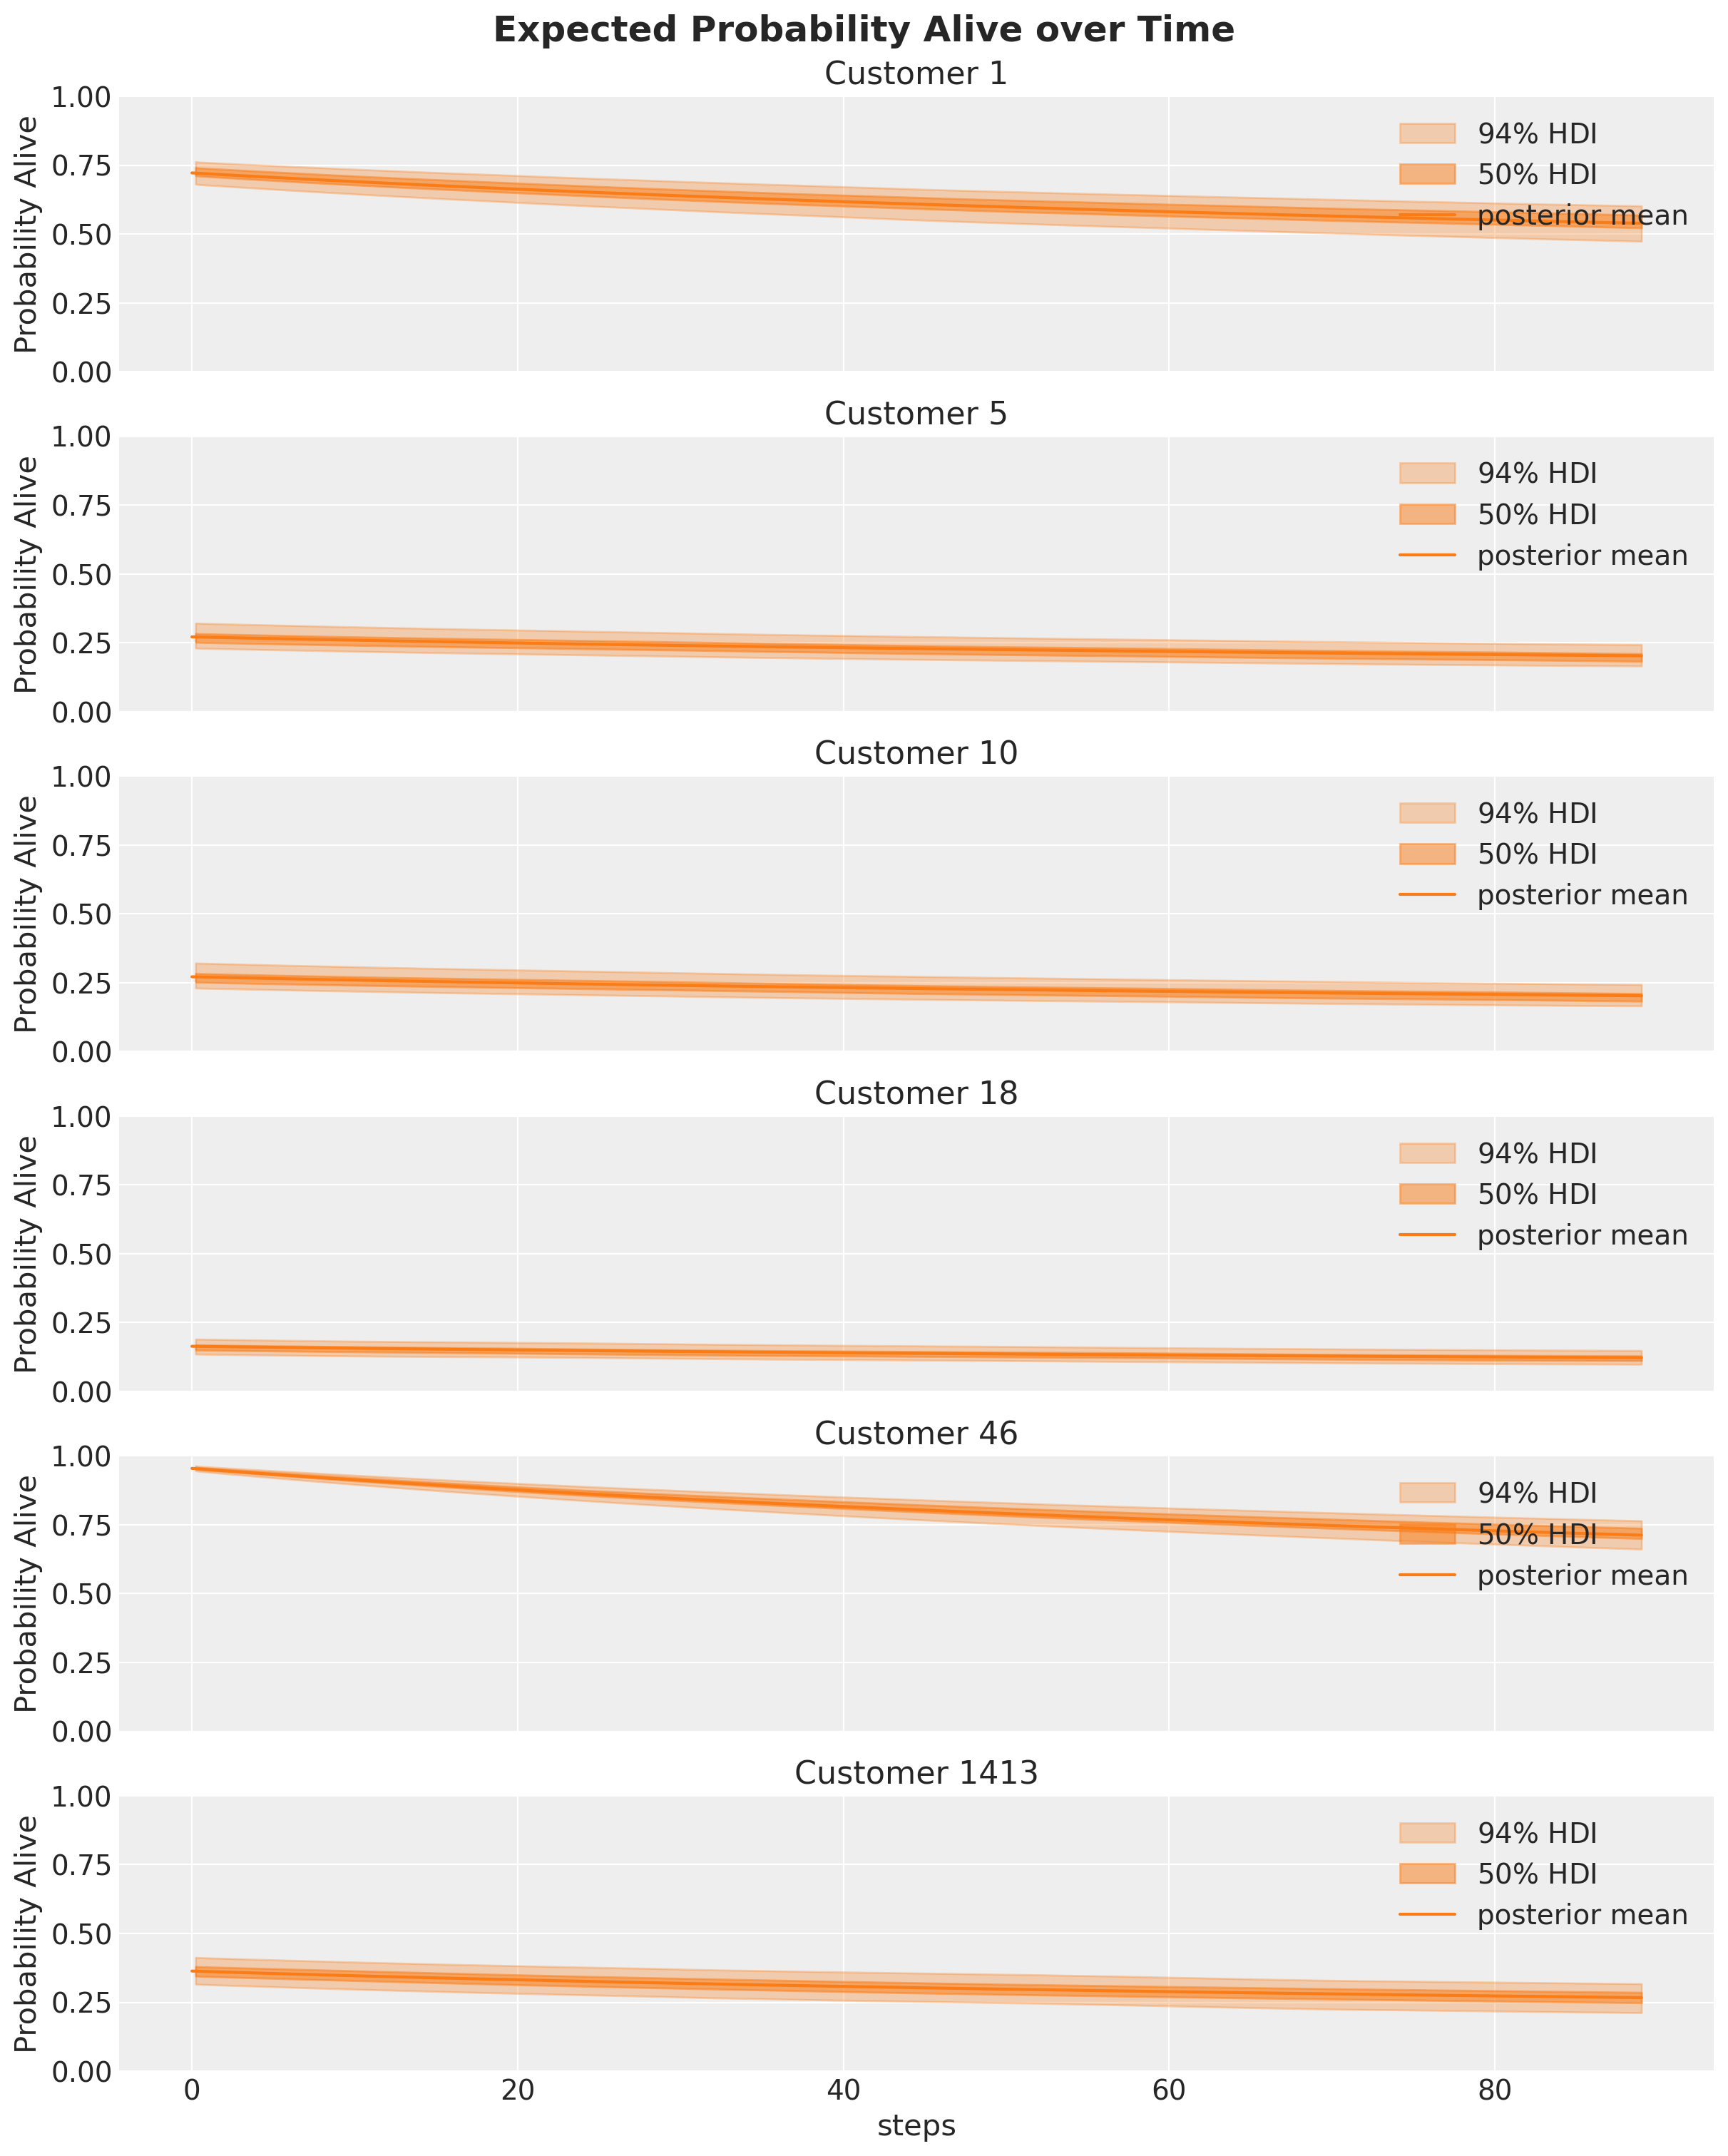

In [101]:
fig, axes = plt.subplots(
    nrows=len(example_customer_ids),
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    customer_expected_probability_alive_steps = expected_probability_alive_steps.sel(
        customer_id=customer_id
    )
    az.plot_hdi(
        range(steps),
        customer_expected_probability_alive_steps,
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        range(steps),
        customer_expected_probability_alive_steps,
        hdi_prob=0.5,
        color="C1",
        fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
        ax=ax,
    )
    ax.plot(
        range(steps),
        customer_expected_probability_alive_steps.mean(dim=("chain", "draw")),
        color="C1",
        label="posterior mean",
    )
    ax.legend(loc="upper right")
    ax.set(title=f"Customer {customer_id}", ylabel="Probability Alive", ylim=(0, 1))

axes[-1].set(xlabel="steps")
plt.gcf().suptitle(
    "Expected Probability Alive over Time", fontsize=18, fontweight="bold"
);

In [24]:
# Append all predictive methods to a pandas dataframe
#df['exp_prchs_mcmc'] = pnbd_mcmc.expected_purchases(future_t = 10).mean(("chain", "draw"))
df['exp_prchs_map'] = pnbd_map.expected_purchases(future_t = 10).mean(("chain", "draw"))

#df['prob_alive_mcmc'] = pnbd_mcmc.expected_probability_alive(future_t = 10).mean(("chain", "draw"))
df['prob_alive_map'] = pnbd_map.expected_probability_alive(future_t = 10).mean(("chain", "draw"))

#df['prchs_prob_mcmc'] = pnbd_mcmc.expected_purchase_probability(n_purchases=3,future_t=30).mean(("chain", "draw"))
df['prchs_prob_map'] = pnbd_map.expected_purchase_probability(n_purchases=3,future_t=30).mean(("chain", "draw"))

# This value does not change from customer to customer, but is shown here for completeness
#df['new_customer_mcmc'] = pnbd_mcmc.expected_purchases_new_customer(t = 100).mean().values
df['new_customer_map'] = pnbd_map.expected_purchases_new_customer(t = 100).mean().values

# For single customer predictions, arguments must still be provided as lists or numpy arrays
# Array lengths must match for all arguments
# pnbd_mcmc.expected_purchases(future_t = 10,
#                              customer_id = [1000],
#                              frequency = np.array([3]),
#                              recency = [20],
#                              T = [30]).mean(("chain", "draw"))

# # Use a for loop or list comprehension to iterate over multiple arguments:
# [pnbd_mcmc.expected_purchases(future_t = t) for t in [10,9,8]]

df.head(10)

/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.8/site-packages/arviz/data/inference_data.py:152: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/models/pareto_nbd.py:175: UserWarning: The Pareto/NBD model is still experimental. Please see code examples in documentation if model fitting issues are encountered.
  warnings.warn(


,frequency,recency,T,monetary_value,customer_id,exp_prchs_mcmc,exp_prchs_map,prob_alive_mcmc,prob_alive_map,prchs_prob_map,new_customer_map
0,2,30.43,38.86,22.35,0,0.426163,0.429898,0.781540,0.789804,0.082505,2.257801
1,1,1.71,38.86,11.77,1,0.049964,0.050083,0.150524,0.151008,0.008571,2.257801
2,0,0.00,38.86,0.00,2,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
3,0,0.00,38.86,0.00,3,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
4,0,0.00,38.86,0.00,4,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
5,7,29.43,38.86,73.74,5,1.087263,1.102017,0.675588,0.685516,0.110536,2.257801
6,1,5.00,38.86,11.77,6,0.076542,0.077453,0.230524,0.233532,0.013254,2.257801
7,0,0.00,38.86,0.00,7,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
8,2,35.71,38.86,25.55,8,0.469376,0.471763,0.860708,0.866718,0.090540,2.257801
9,0,0.00,38.86,0.00,9,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801


In [98]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Sat Apr 20 2024

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.22.2

pymc    : 5.13.0
pytensor: 2.20.0

arviz         : 0.18.0
pandas        : 2.2.2
xarray        : 2024.3.0
matplotlib    : 3.8.4
pymc          : 5.13.0
pymc_marketing: 0.4.2
sys           : 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:51:49) [Clang 16.0.6 ]

Watermark: 2.4.3

